# Sales Predict

## 0.0. Imports

In [1]:
import math
import numpy  as np
import pandas as pd
import inflection
import seaborn as sns


from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from boruta                import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

### 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def ml_error(model_name,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse},index=[0])

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv( './data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( './data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

## 1.0. Passo 1 - Descrição dos Dados

In [5]:
df1 = df_raw.copy()

### 1.1. Renomeando as colunas

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

### 1.2. Dimensão dos Dados

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


### 1.3. Tipo dos Dados

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5. Substituição dos valores N/A

In [10]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
916271,527,1,2013-04-01,0,0,0,0,b,1,d,c,5830.0,4.0,2008.0,0,NaN,NaN,NaN


In [11]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.6. Mudança de Tipos dos Dados

In [13]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

### 1.7. Descrição Estatística dos Dados

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.7.1. Atributos Numéricos

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/tmp/ipykernel_11216/2399209840.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df1['competition_distance'], kde=False )


<AxesSubplot: xlabel='competition_distance'>

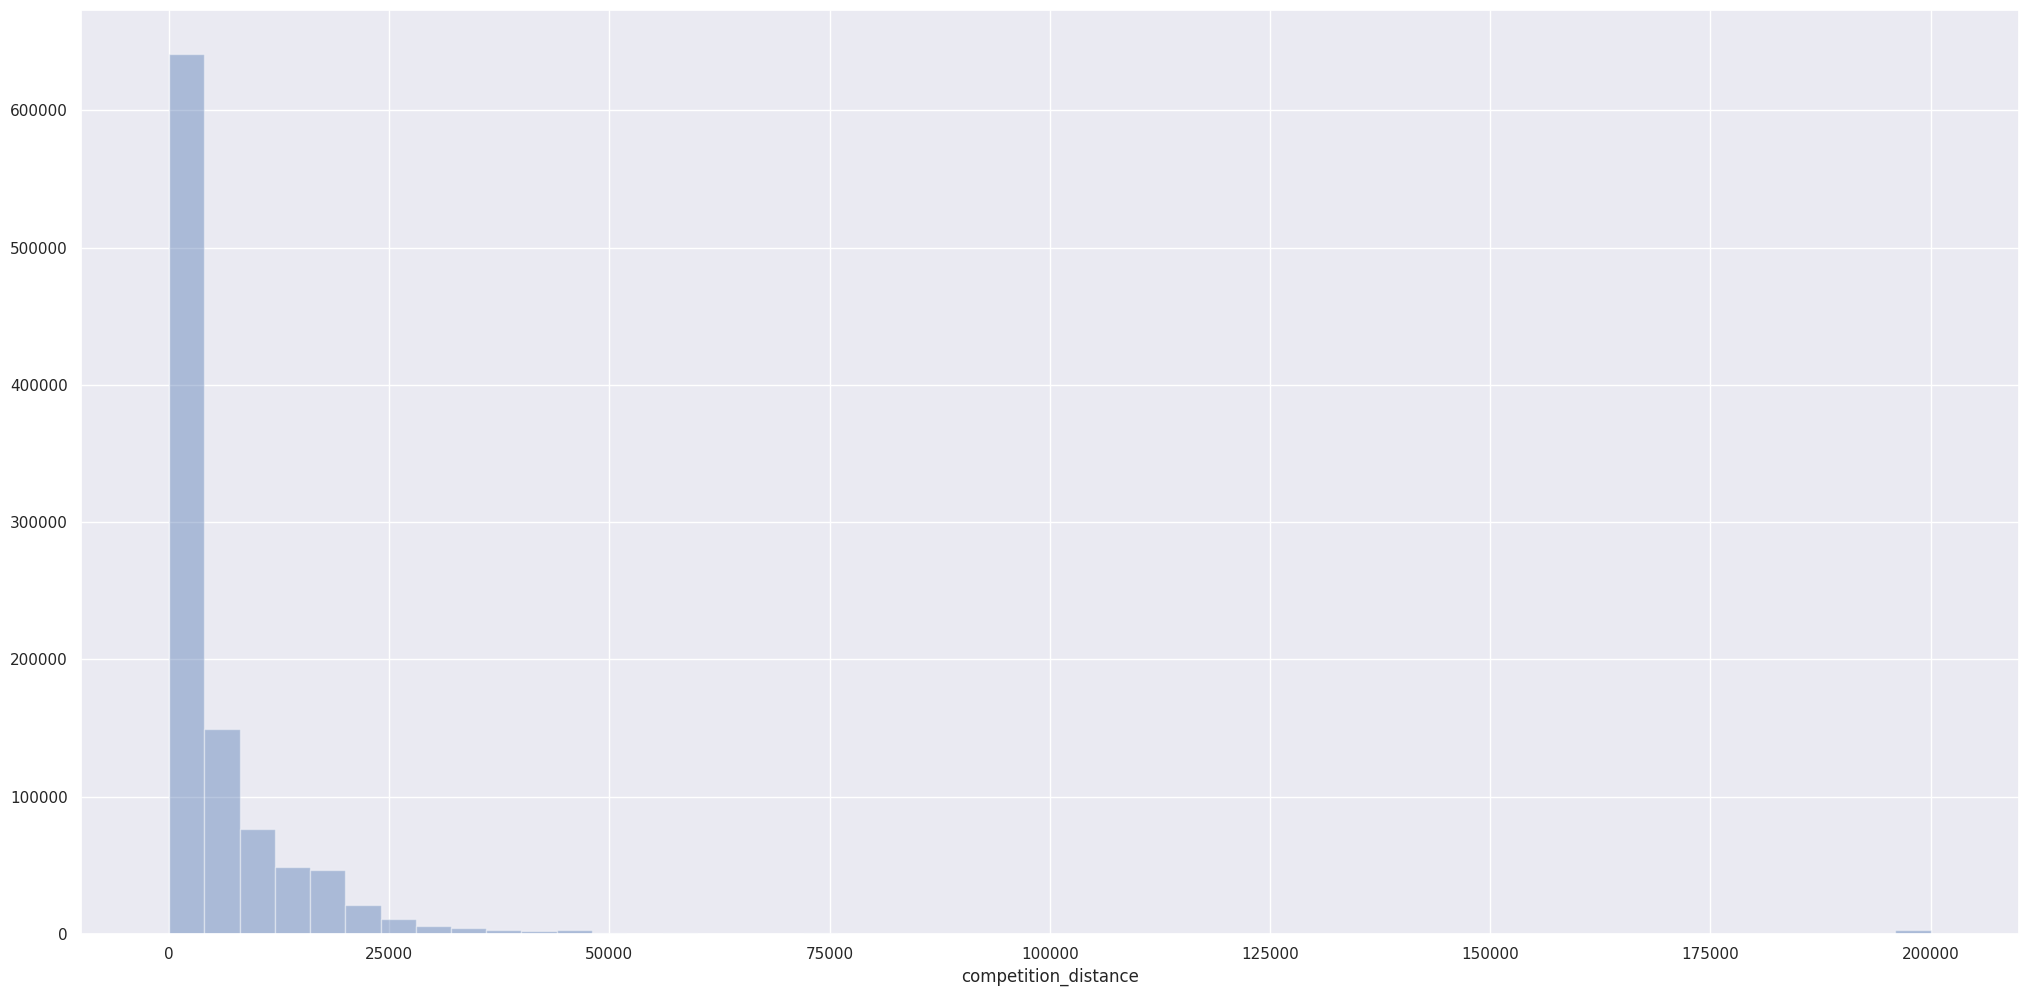

In [16]:
sns.distplot( df1['competition_distance'], kde=False )

#### 1.7.2. Atributos Categóricos

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot: xlabel='assortment', ylabel='sales'>

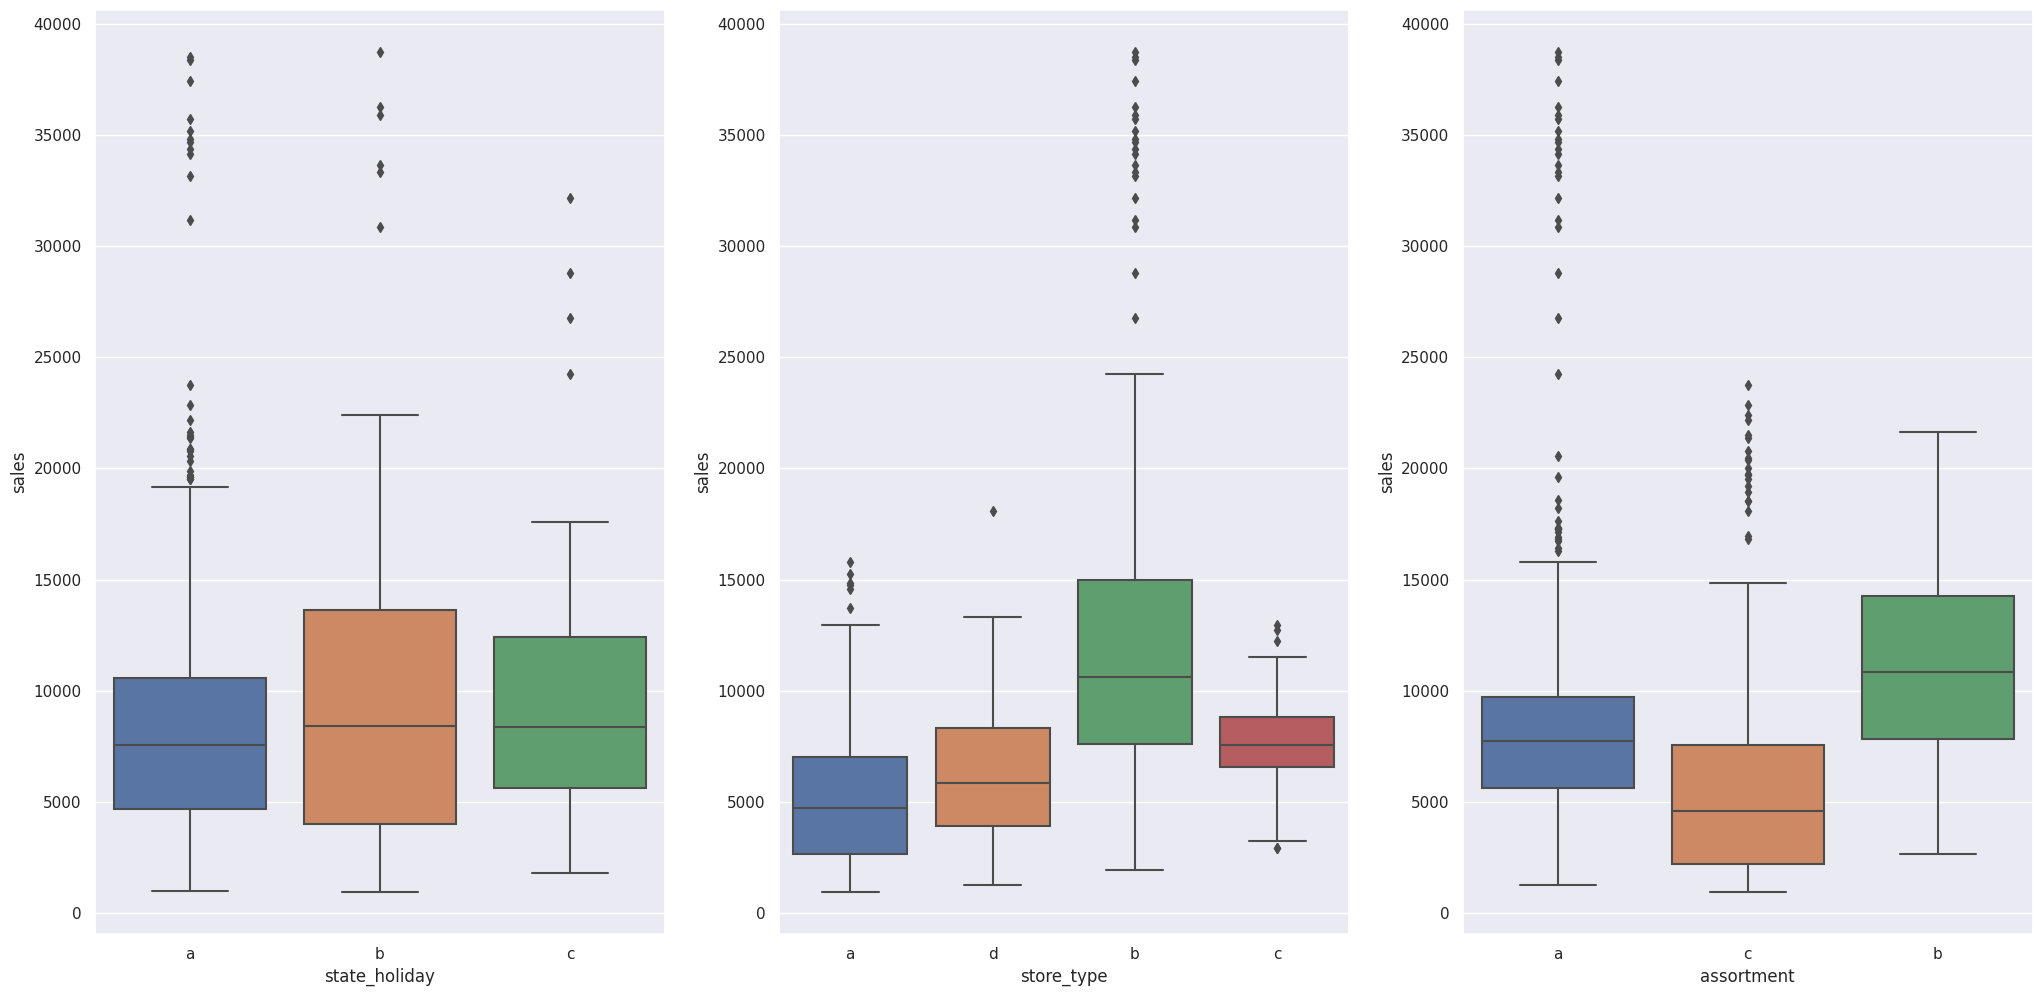

In [18]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

## 2.0. Passo 2 - Feature Engineering

In [19]:
df2 = df1.copy()

### 2.1. Mapa Mental de Hipoteses

In [20]:
Image( './img/MindMap.png' )

### 2.2. Criaçãoo das Hipóteses

#### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

#### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

#### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

#### 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


### 2.4. Feature Engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

/tmp/ipykernel_11216/3893170355.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


## 3.0. Passo 3 - Filtragem das Variaveis

In [22]:
df3 = df2.copy()

### 3.1. Filtragem das Linhas


In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 3.2. Selecao das Colunas

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

## 4.0. Passo 4 - Analise Exploratoria de Dados

In [25]:
df4 = df3.copy()

### 4.1. Analise Univariada

#### 4.1.1. Variavel Resposta

/tmp/ipykernel_11216/1684704756.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df4['sales'], kde=False  )


<AxesSubplot: xlabel='sales'>

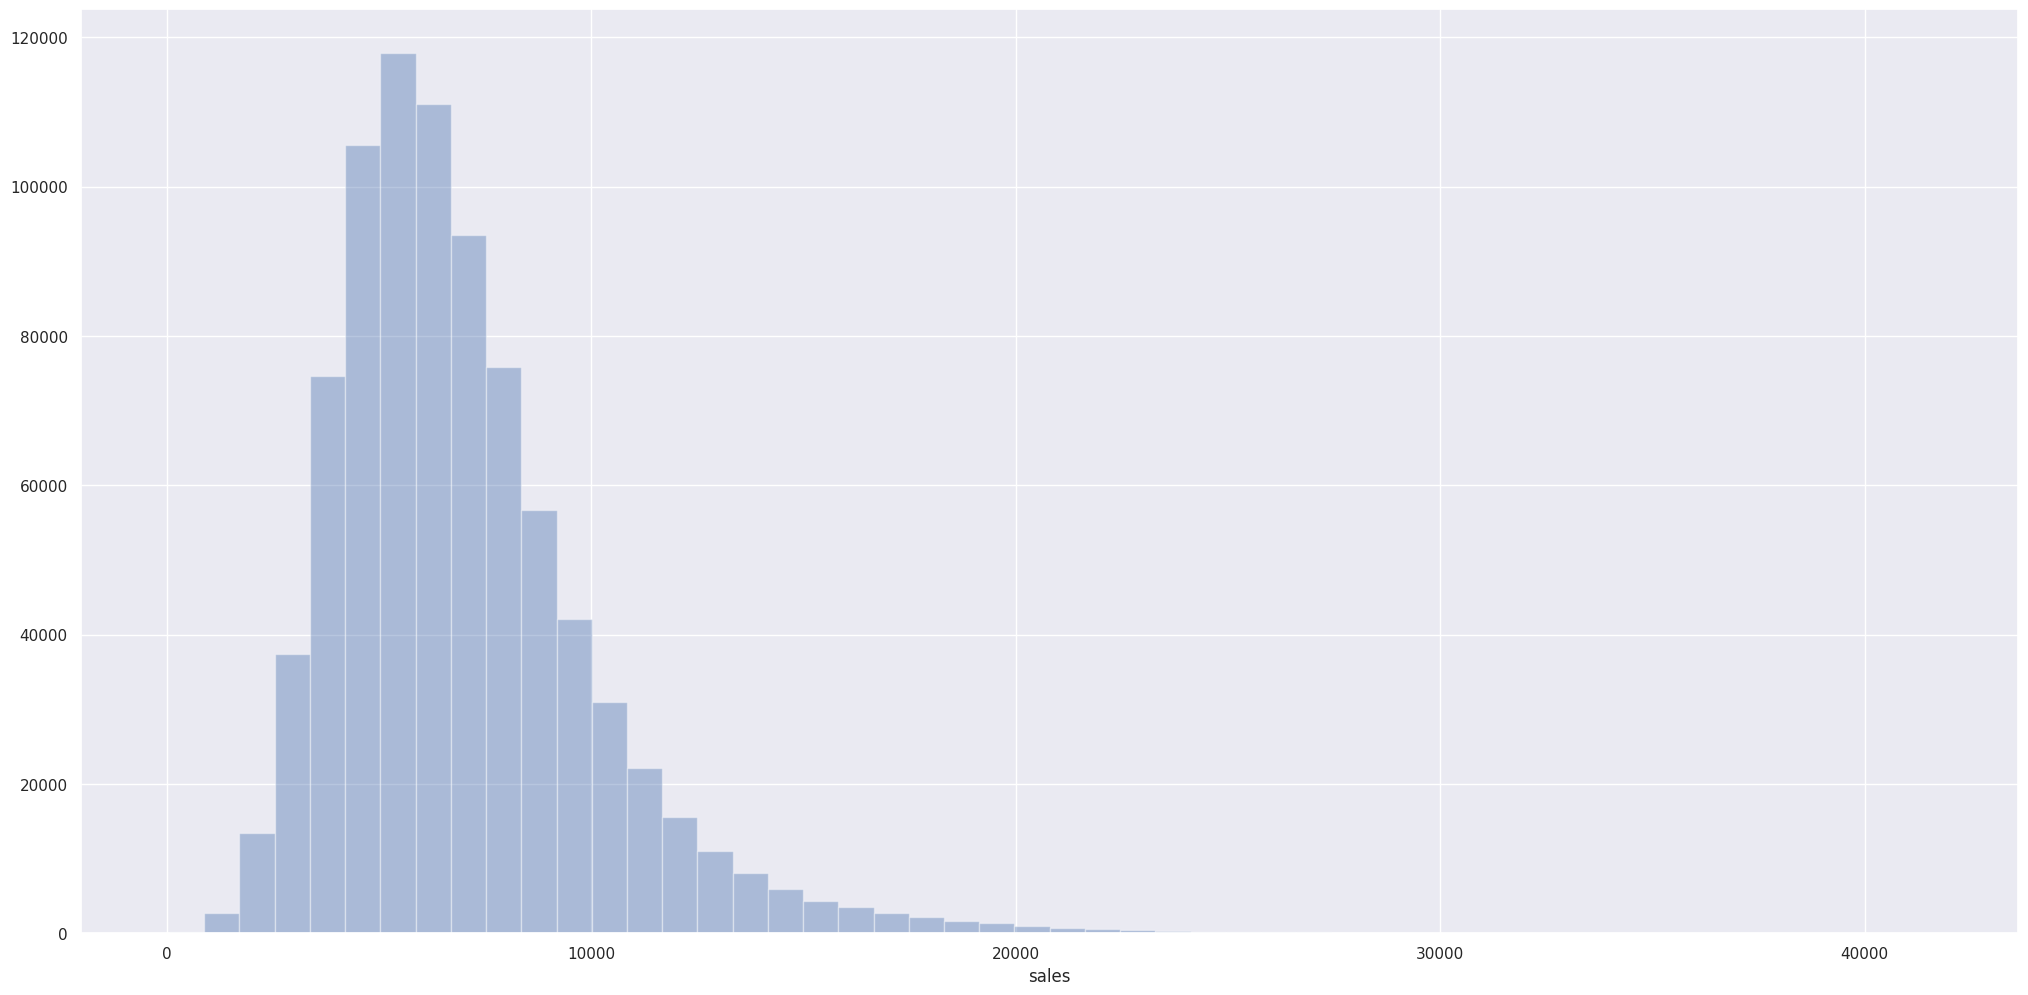

In [26]:
sns.distplot( df4['sales'], kde=False  )

#### 4.1.2. Variaveis Numericas

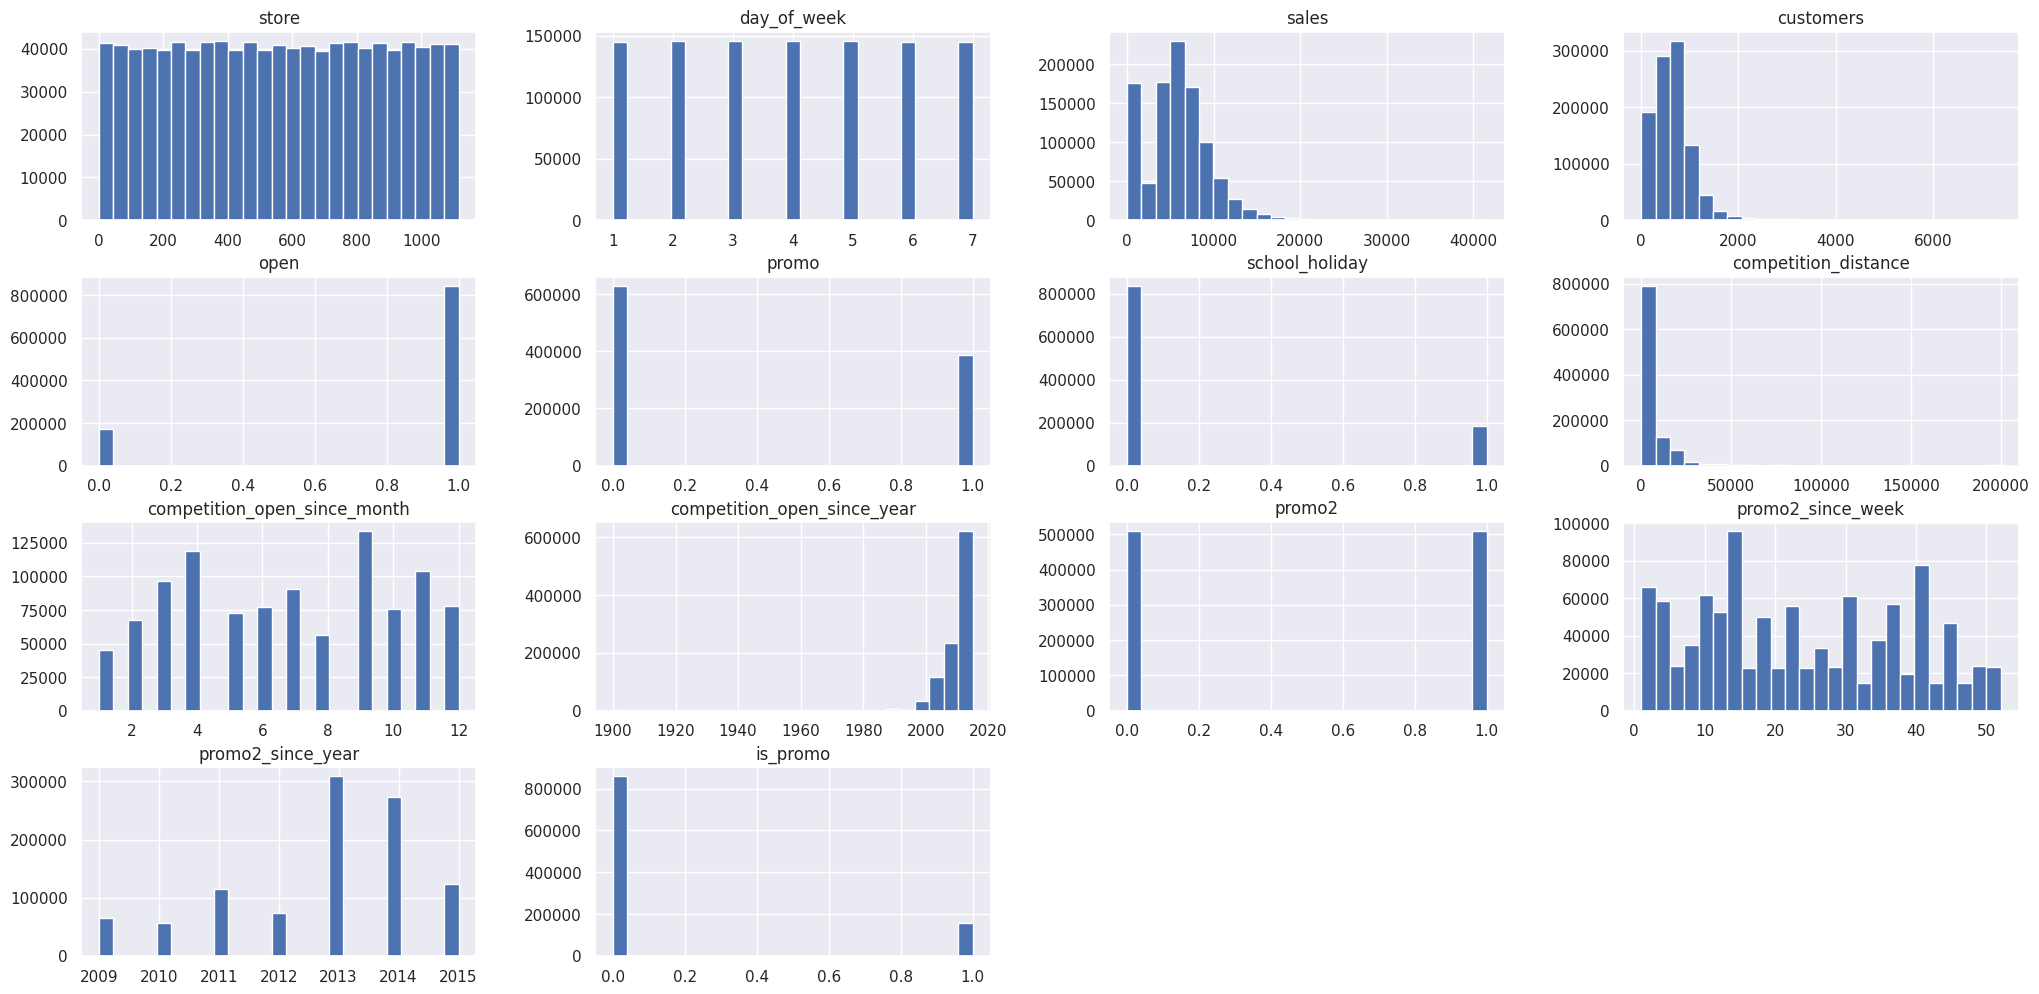

In [27]:
num_attributes.hist( bins=25 );

#### 4.1.3. Variaveis Categoricas

<AxesSubplot: xlabel='sales', ylabel='Density'>

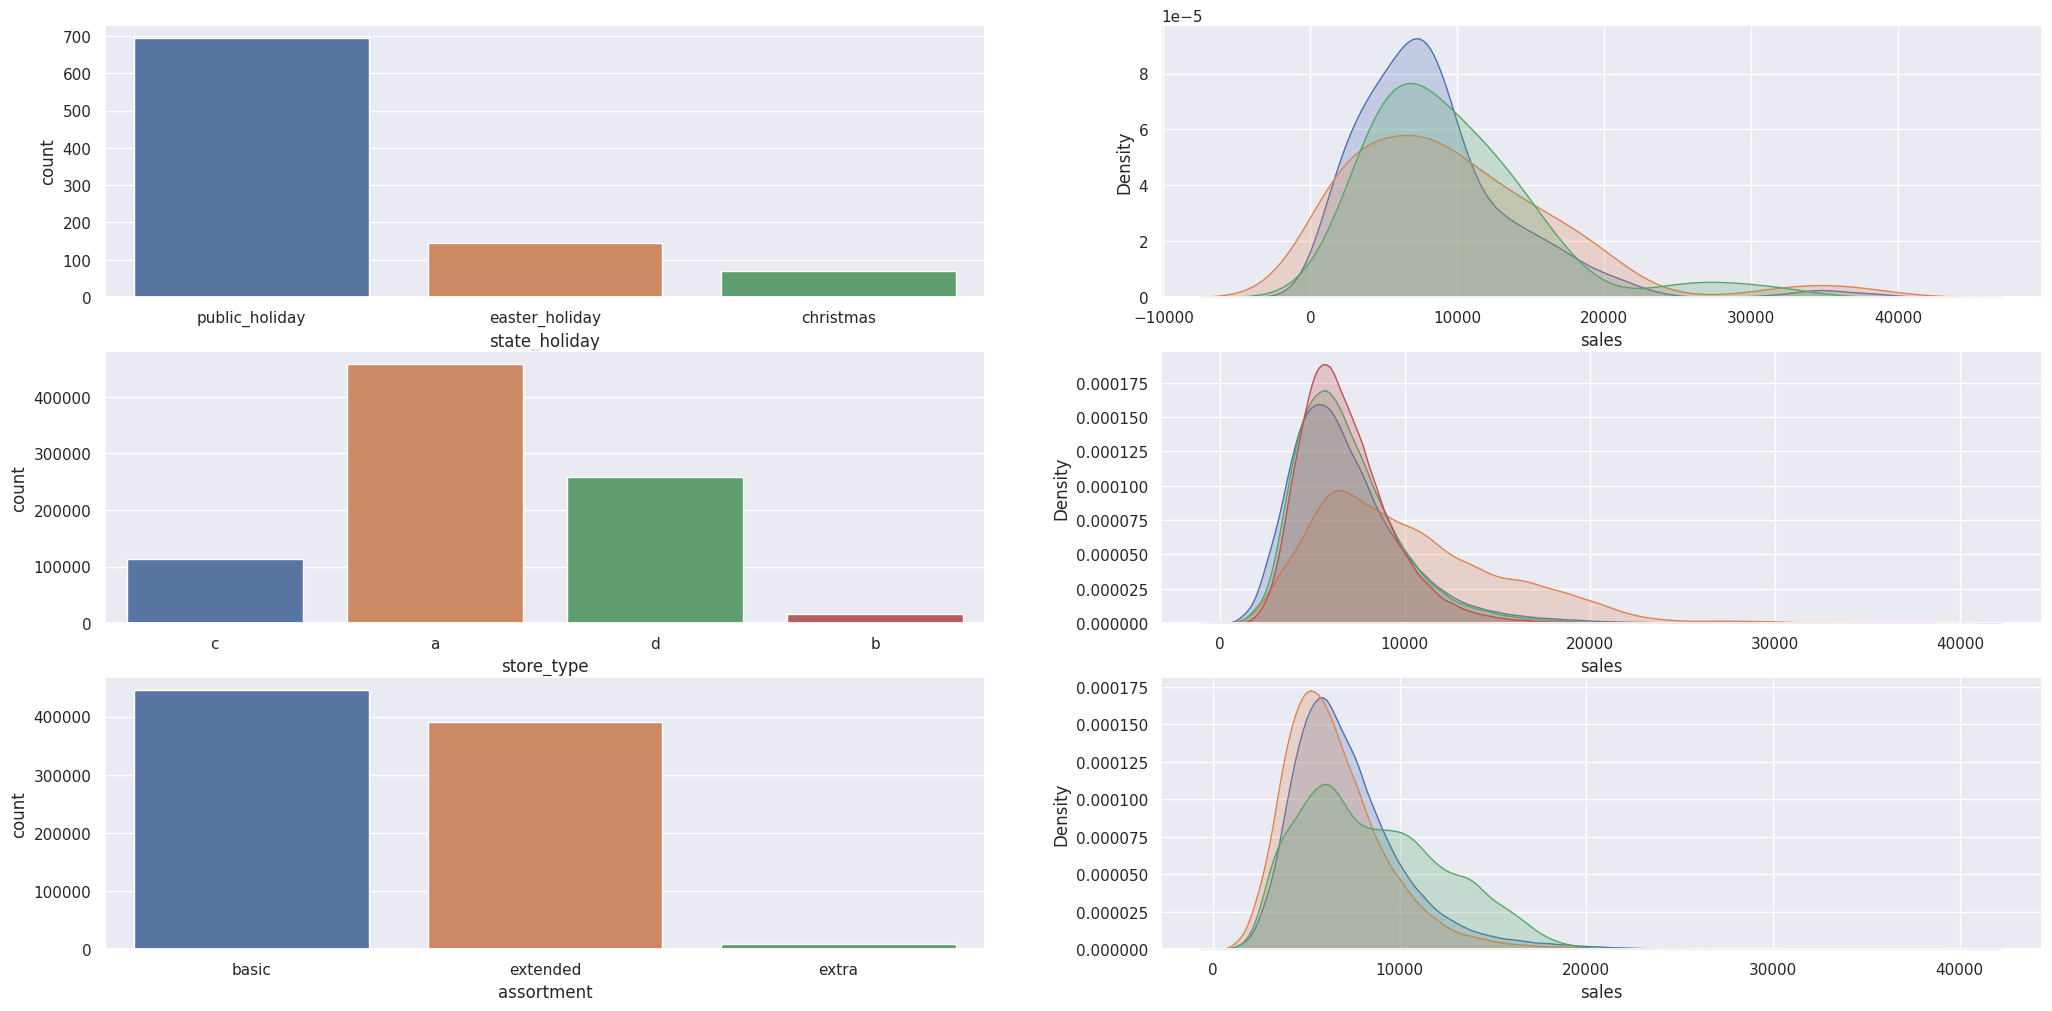

In [28]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot(x=df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot(x=df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

### 4.2. Analise Bivariada

#### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot: xlabel='year_week'>

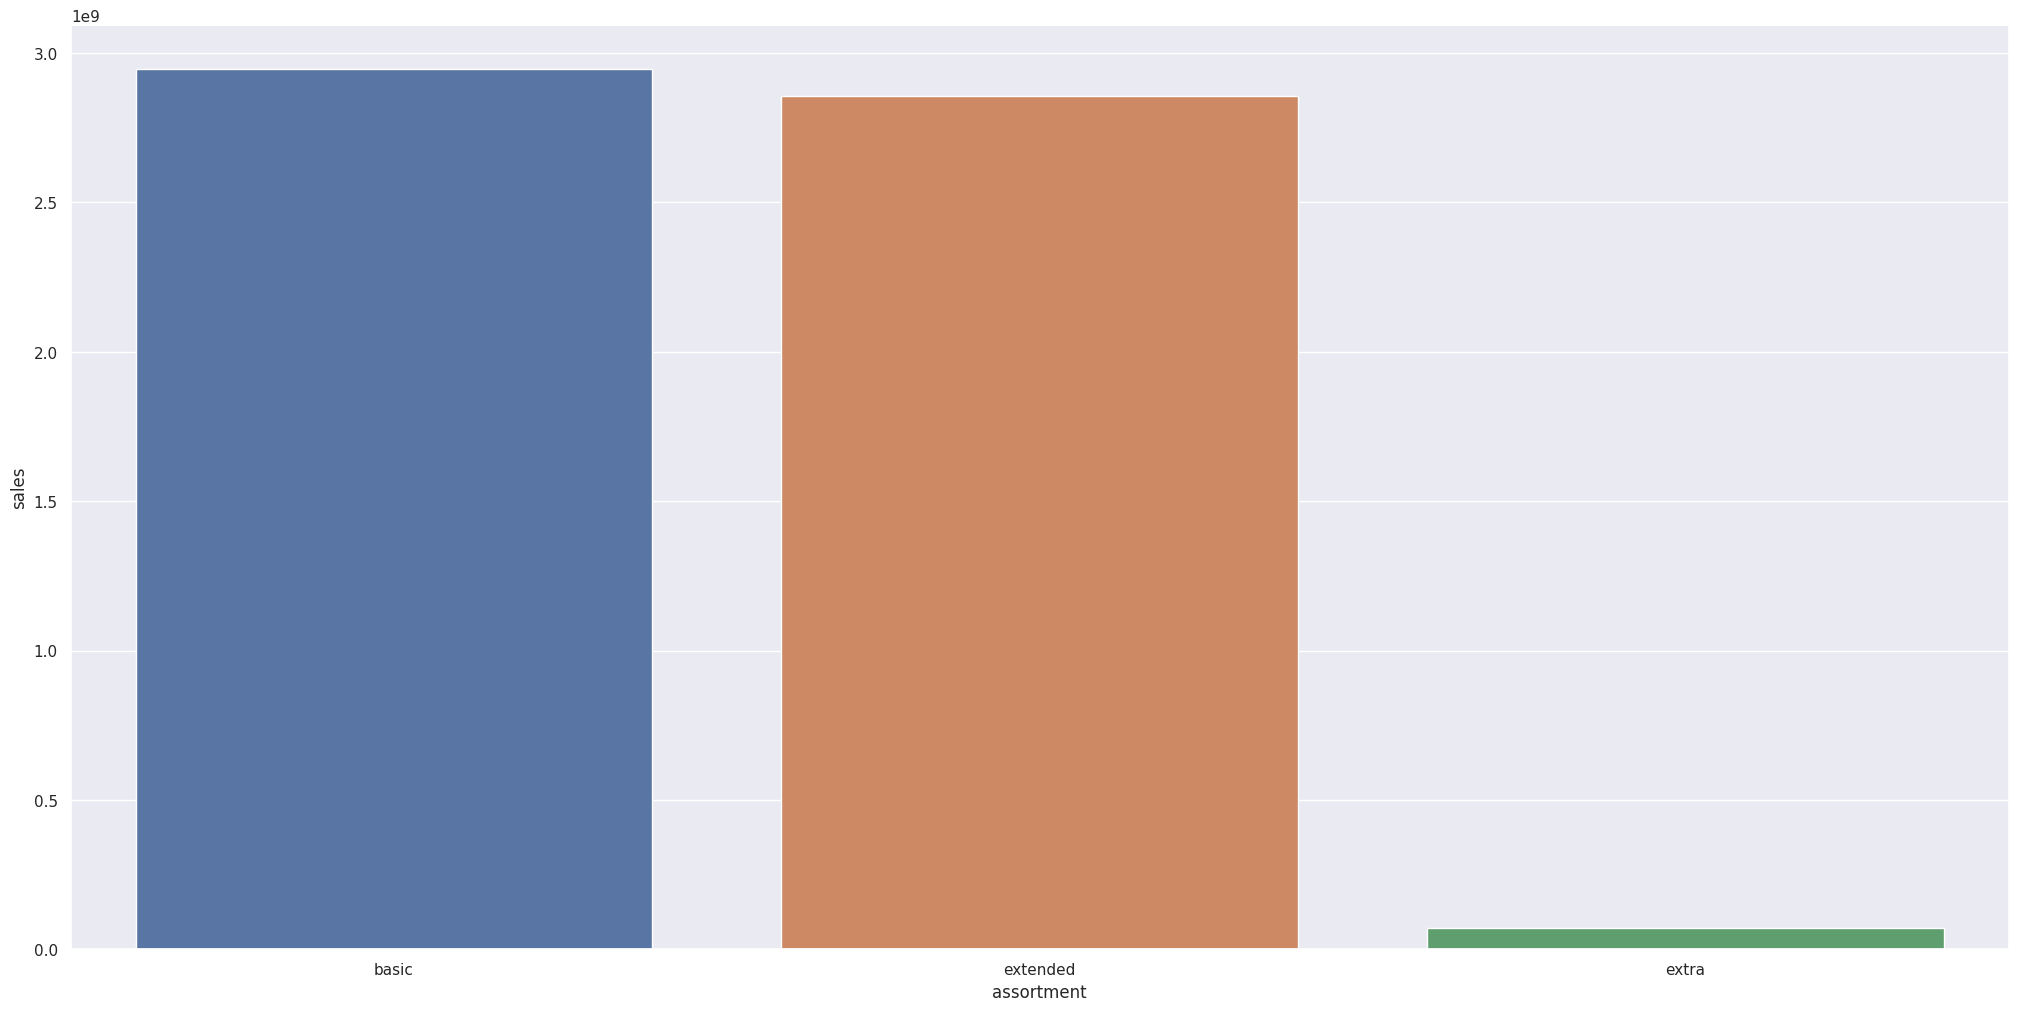

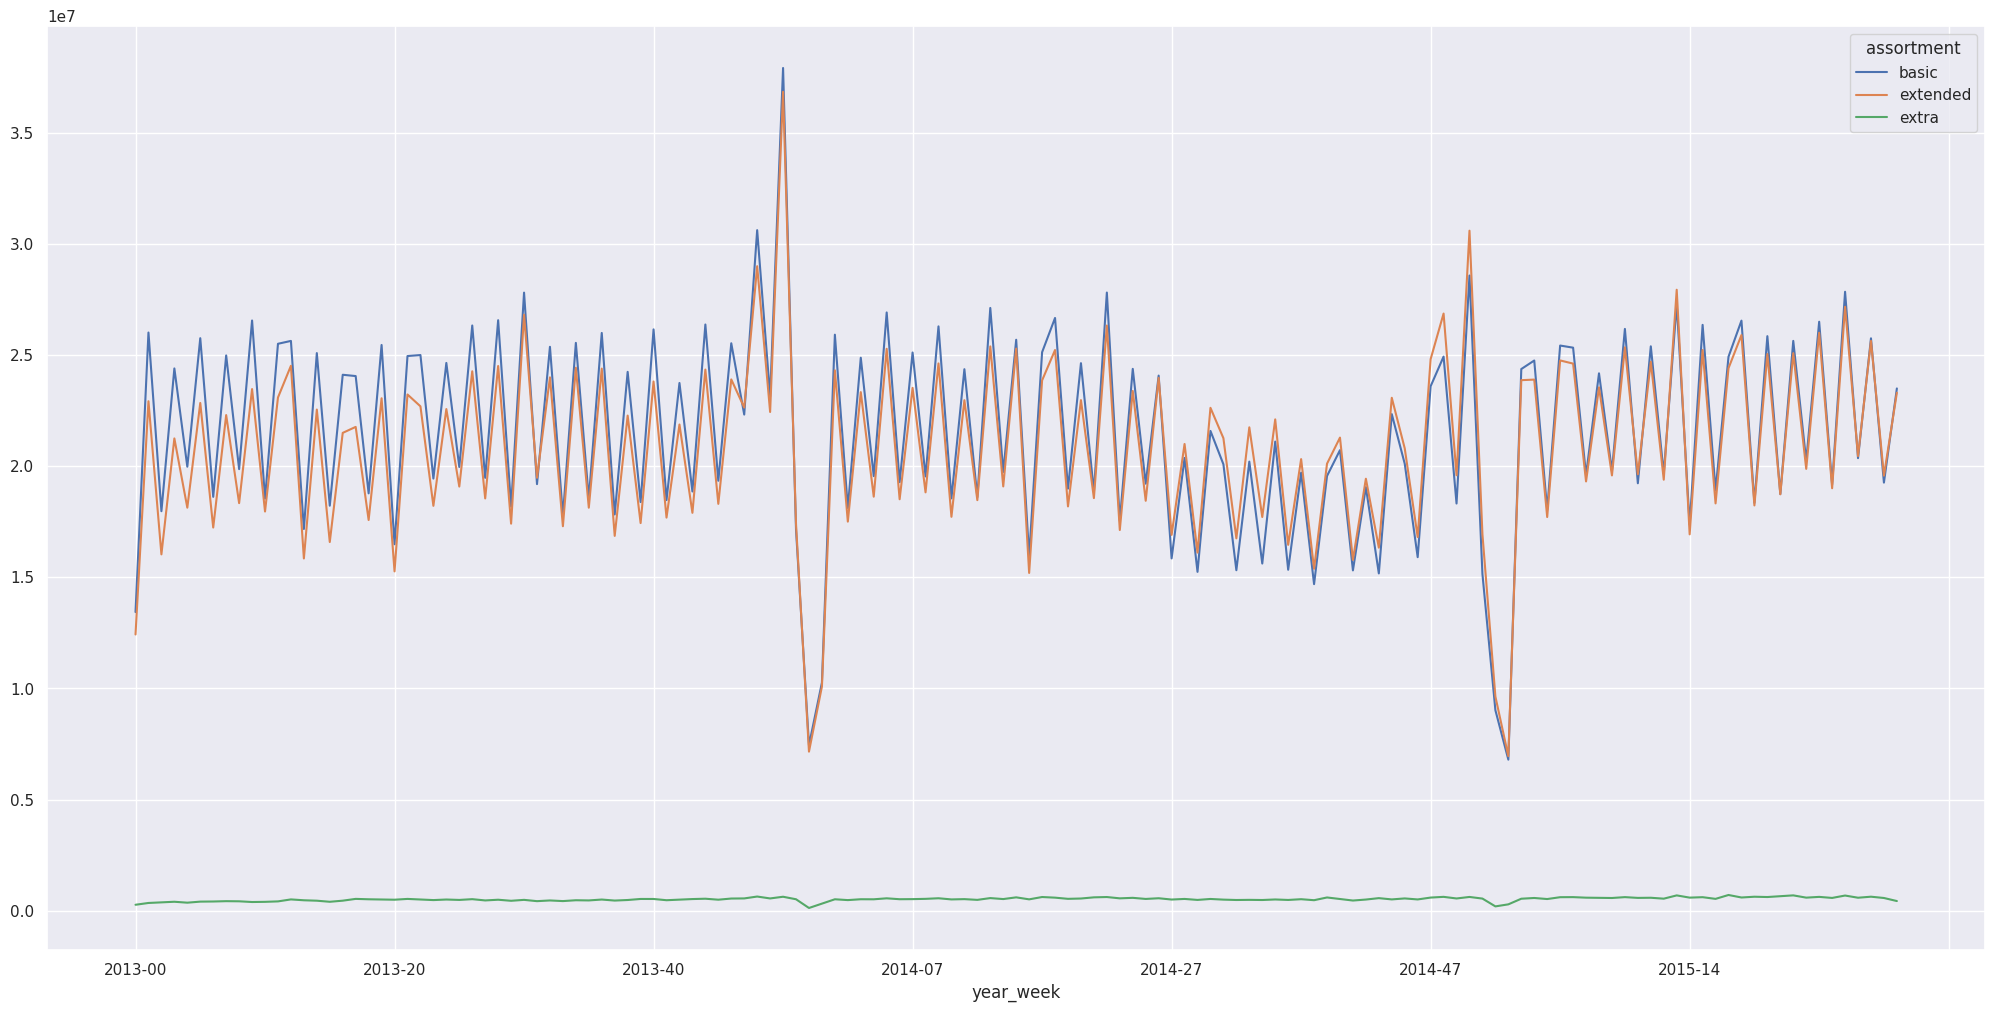

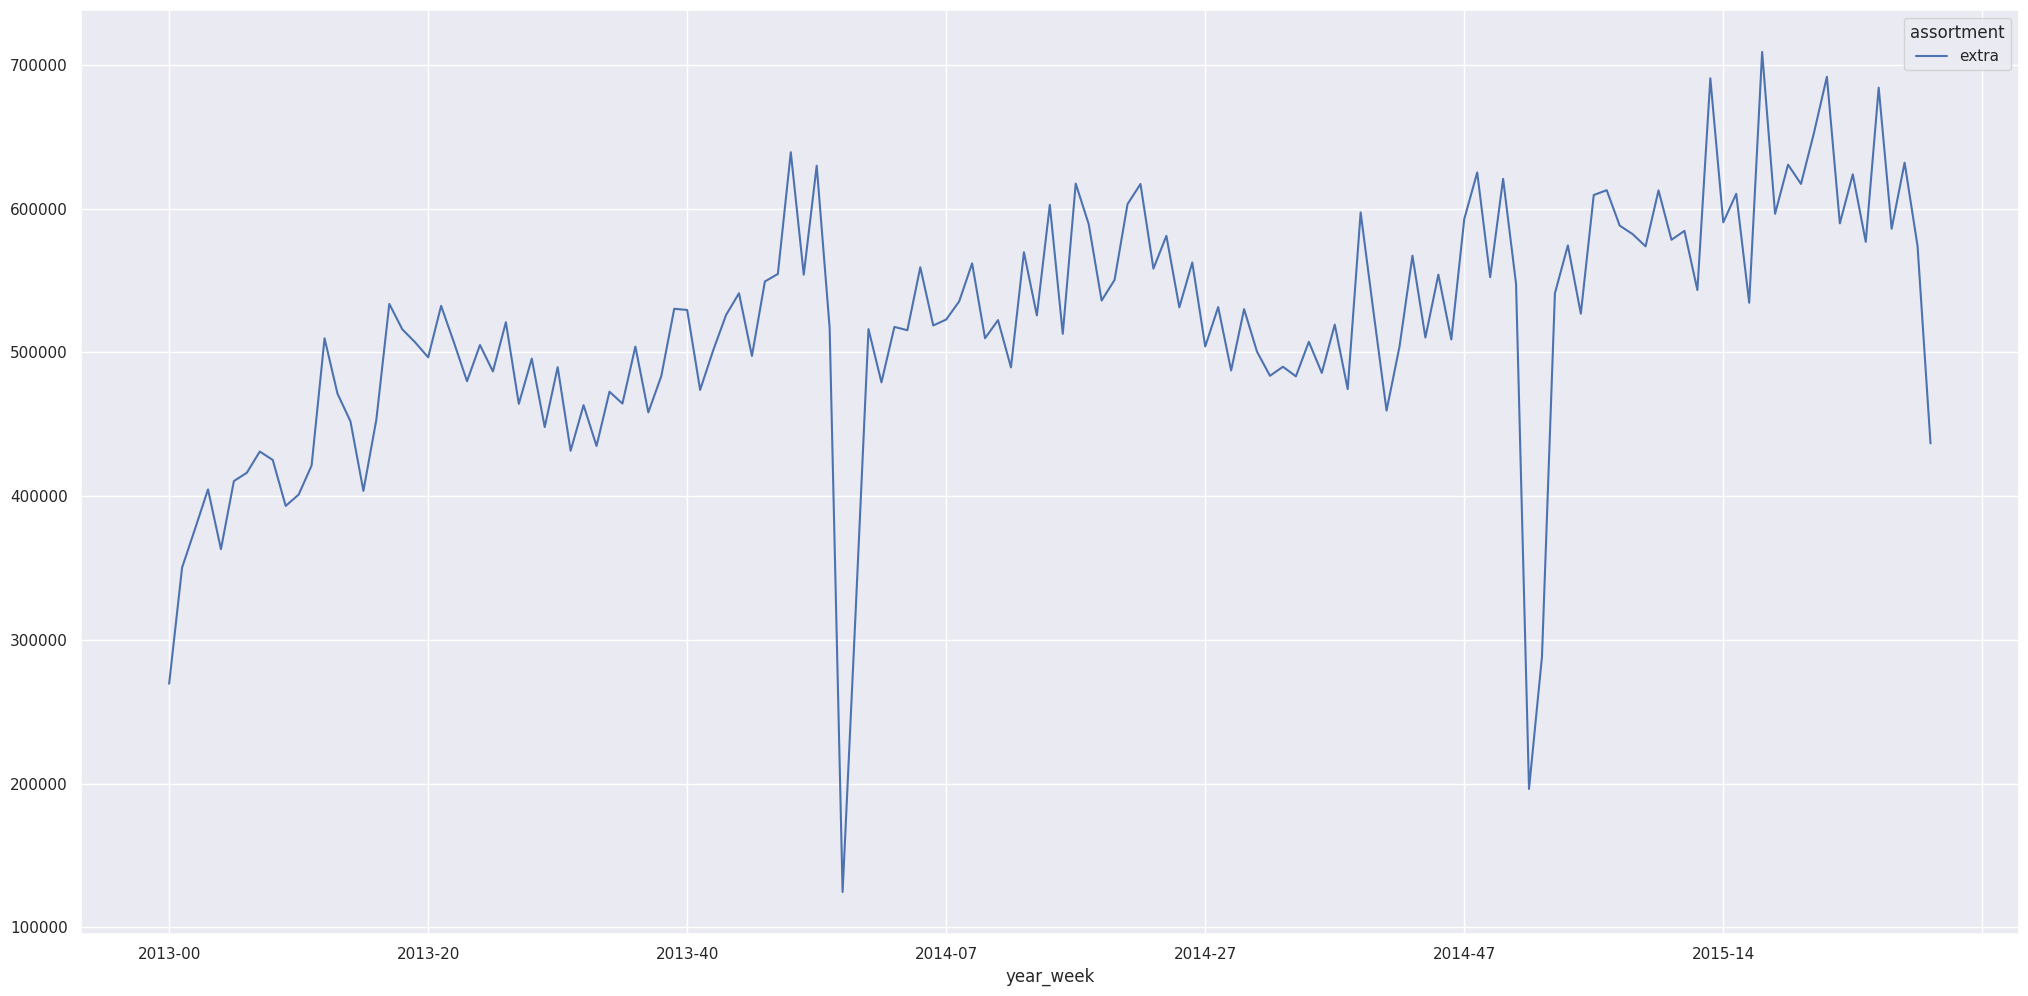

In [29]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

/tmp/ipykernel_11216/2329280681.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );


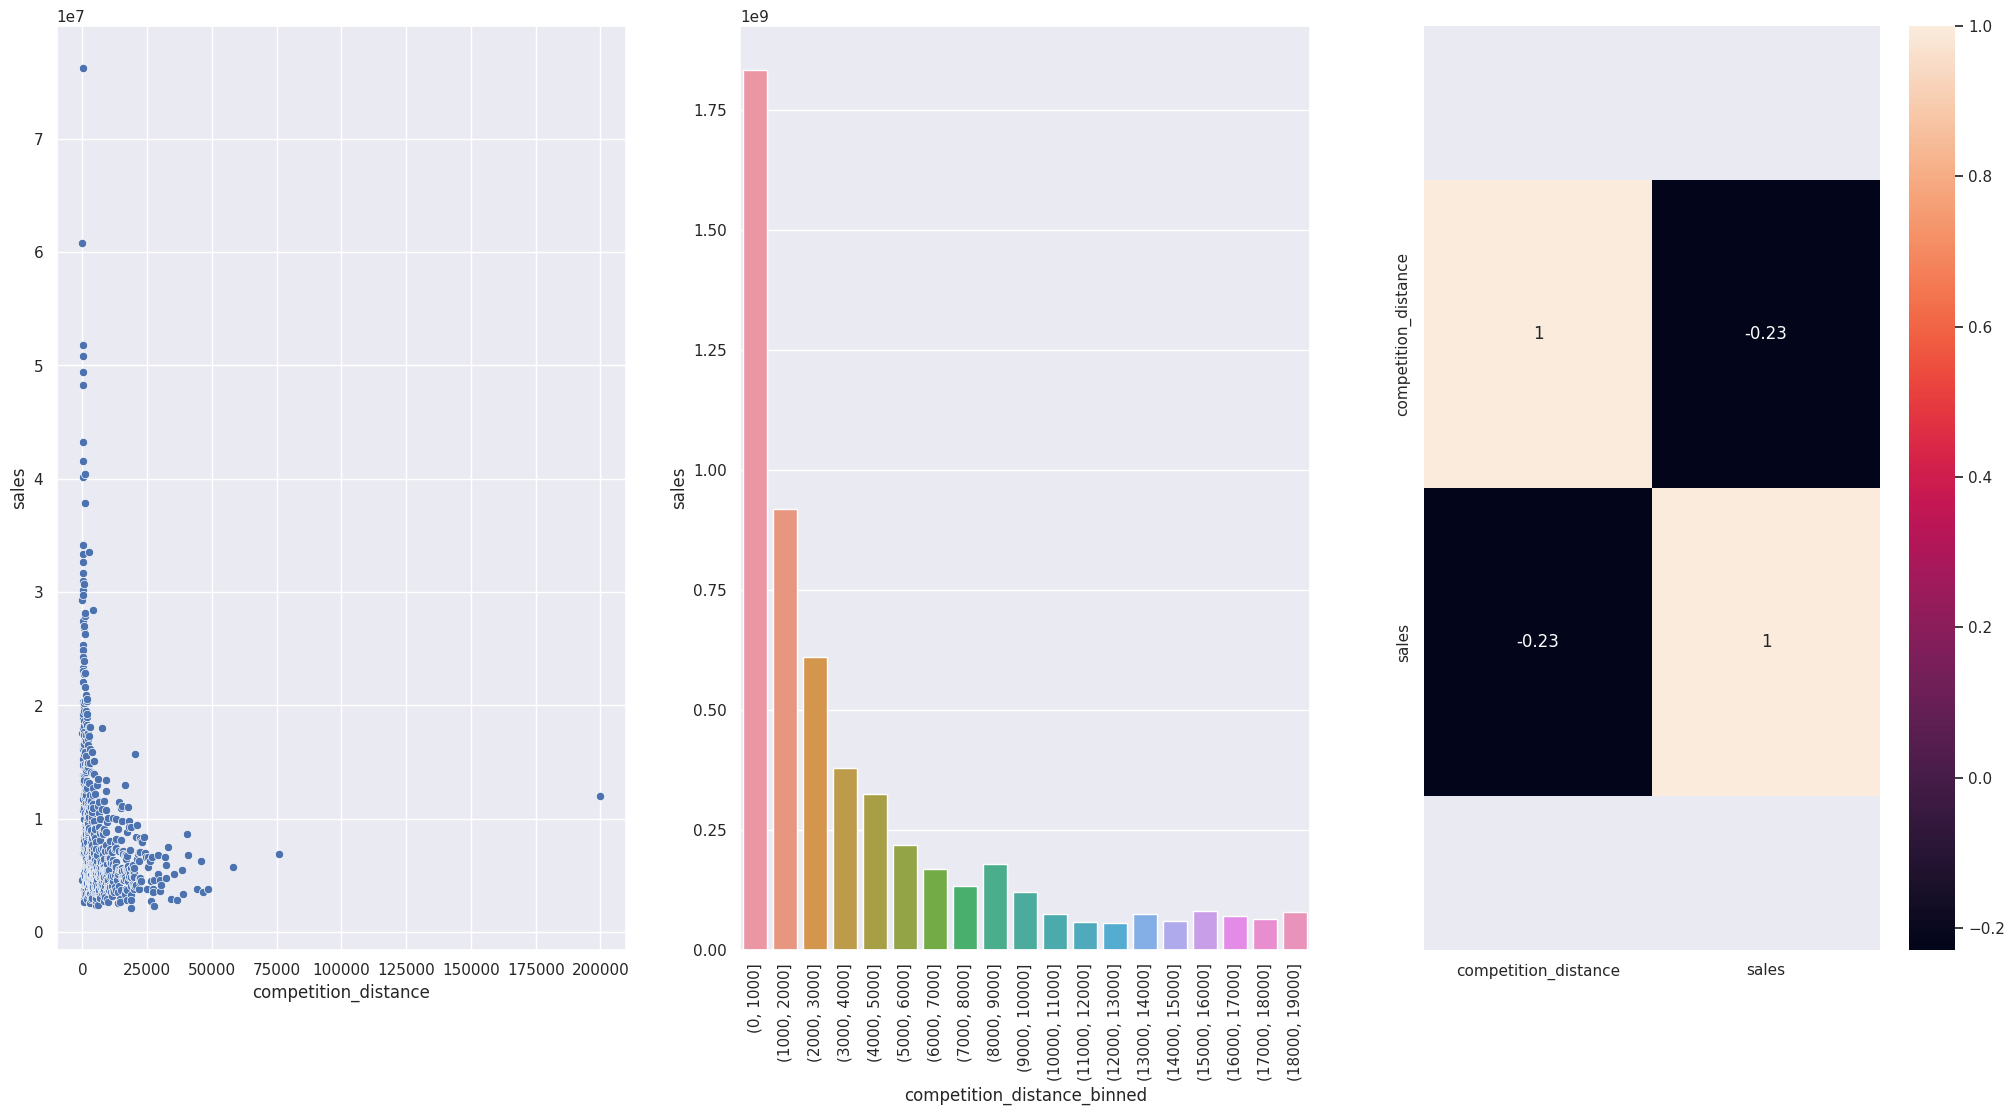

In [30]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

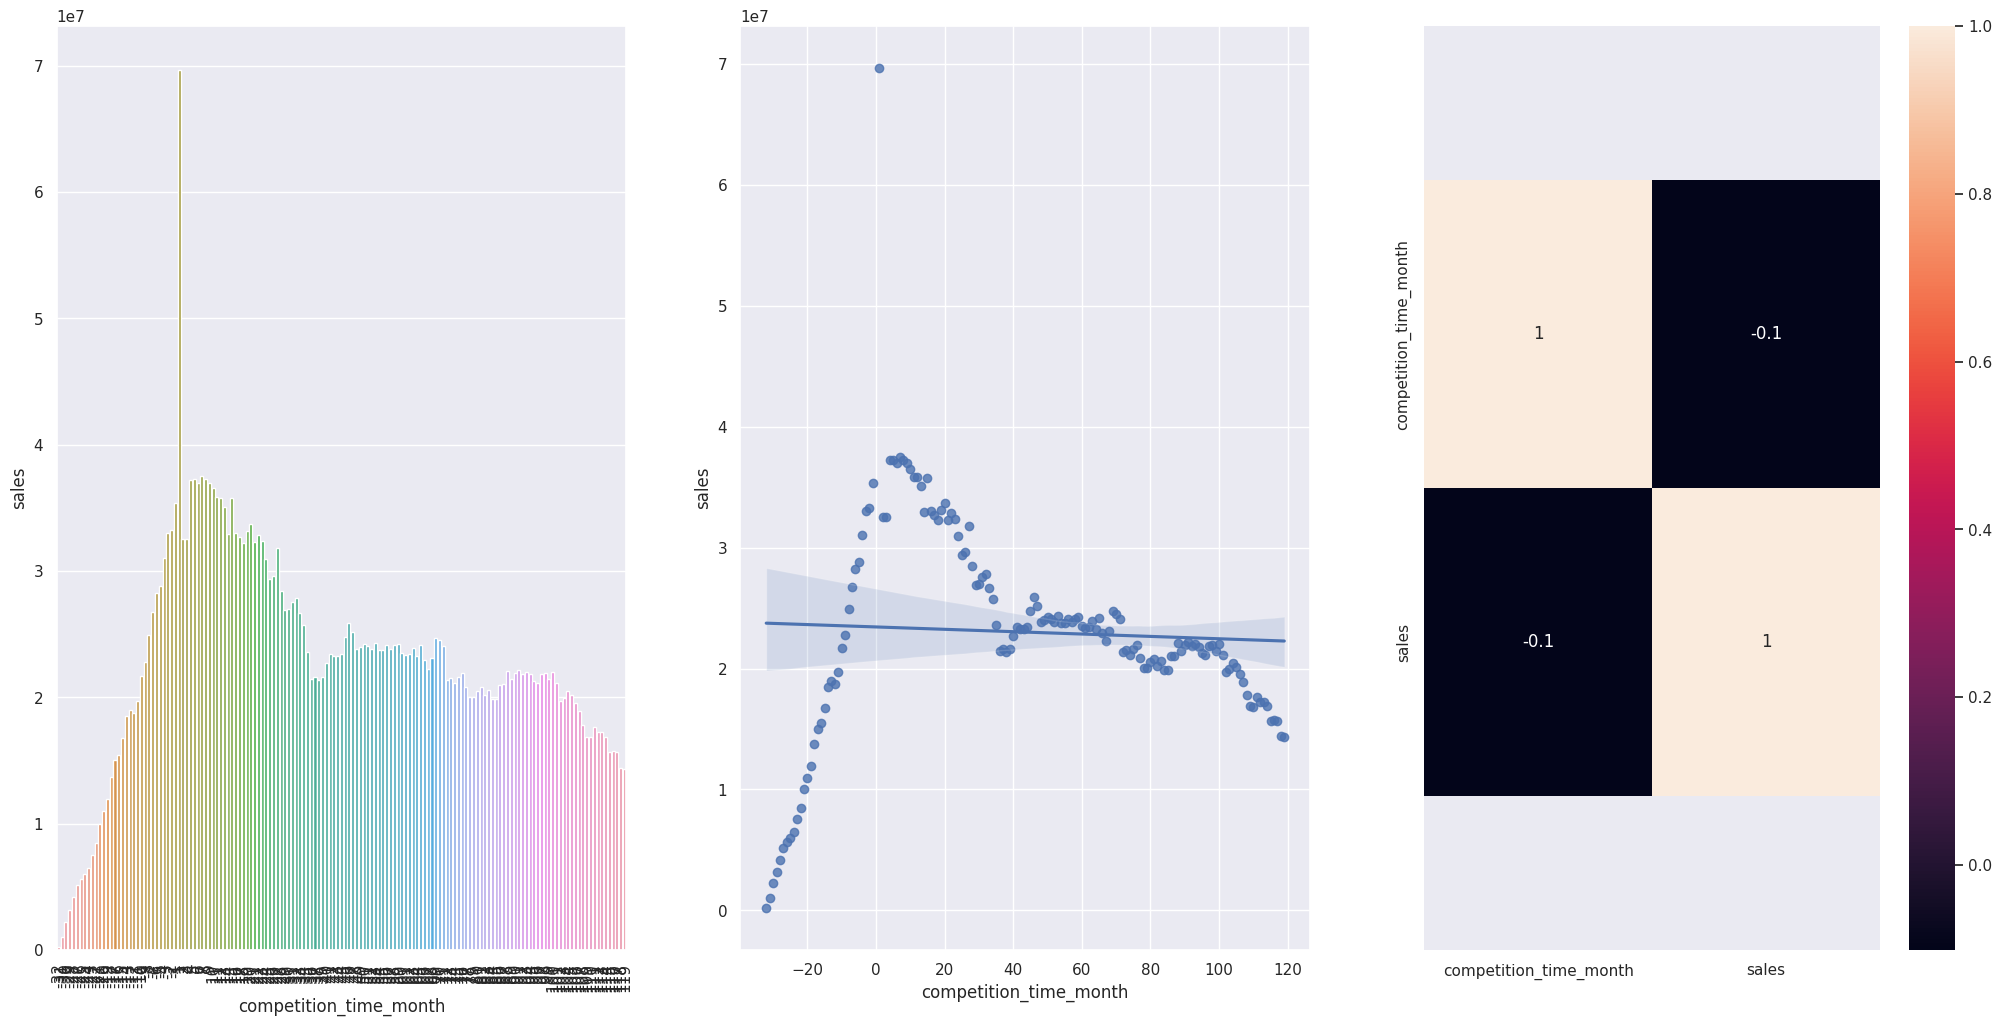

In [31]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo de promocao

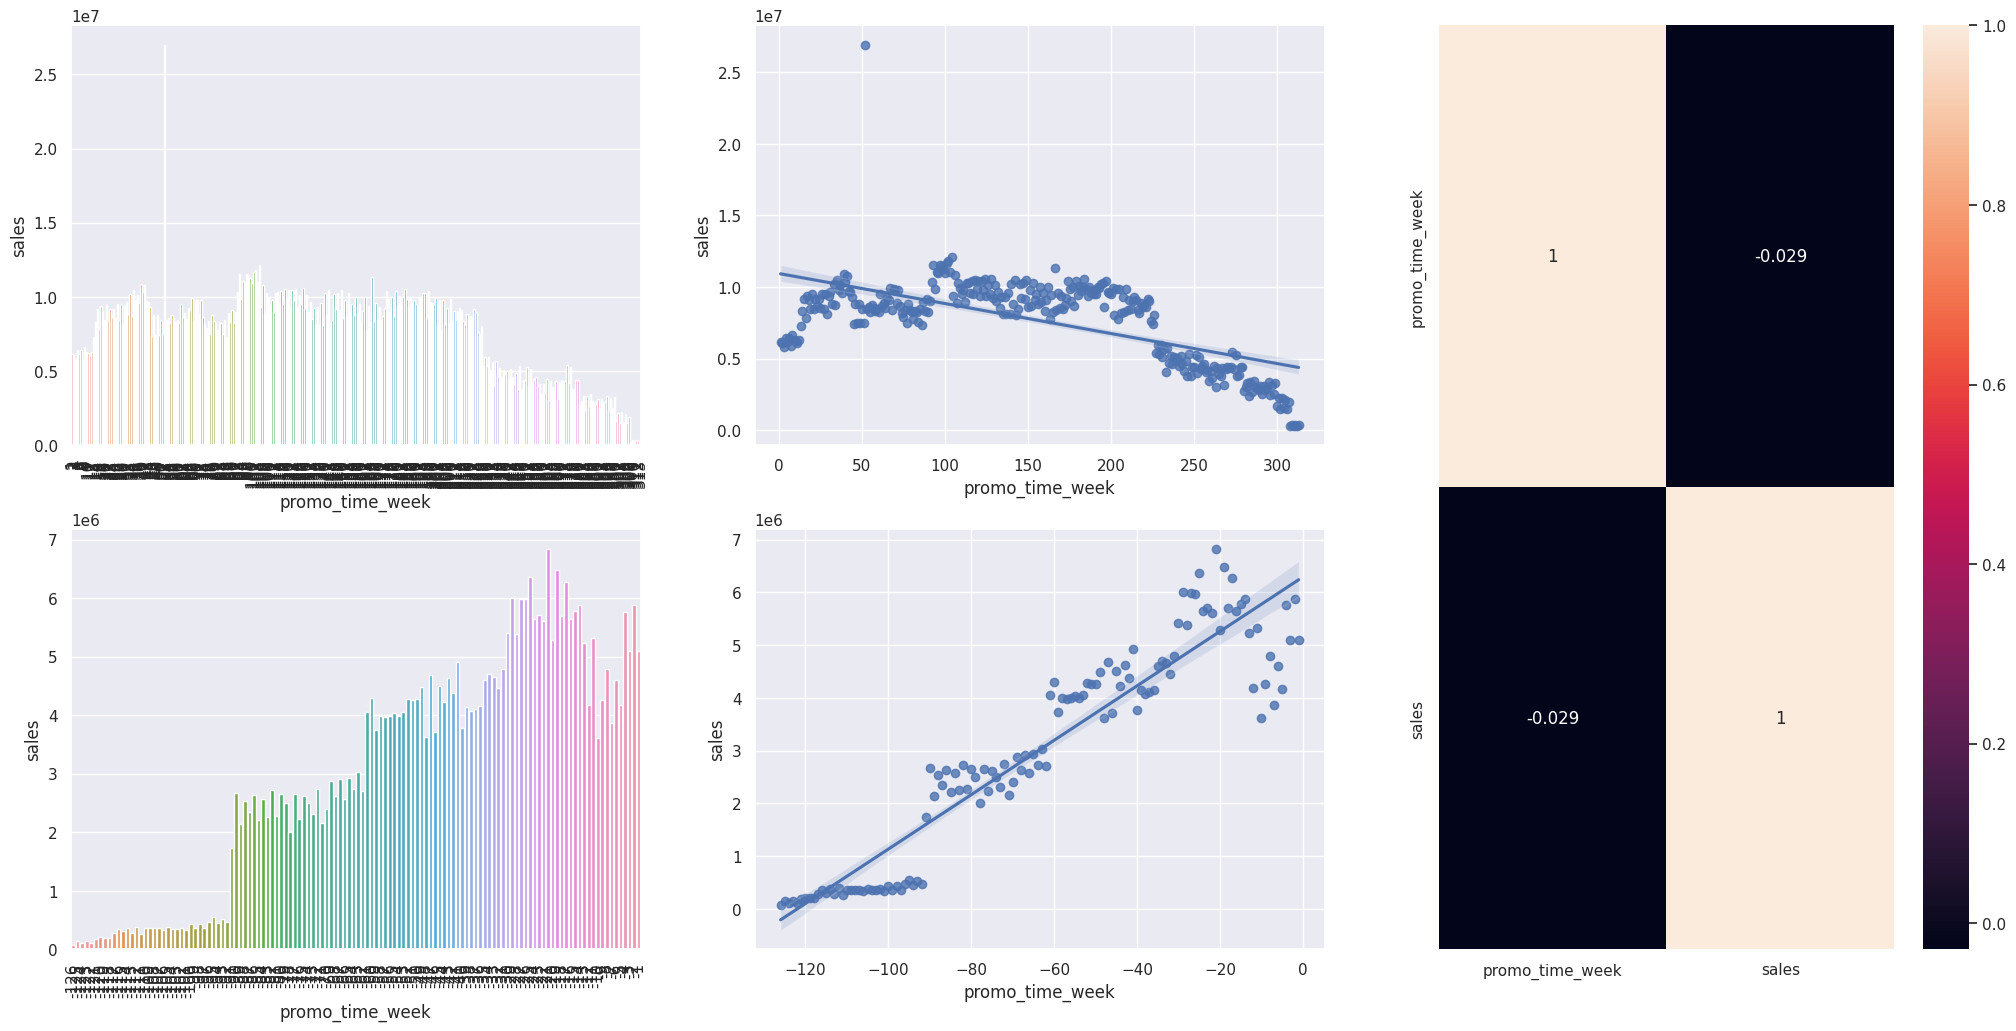

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

#### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [33]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


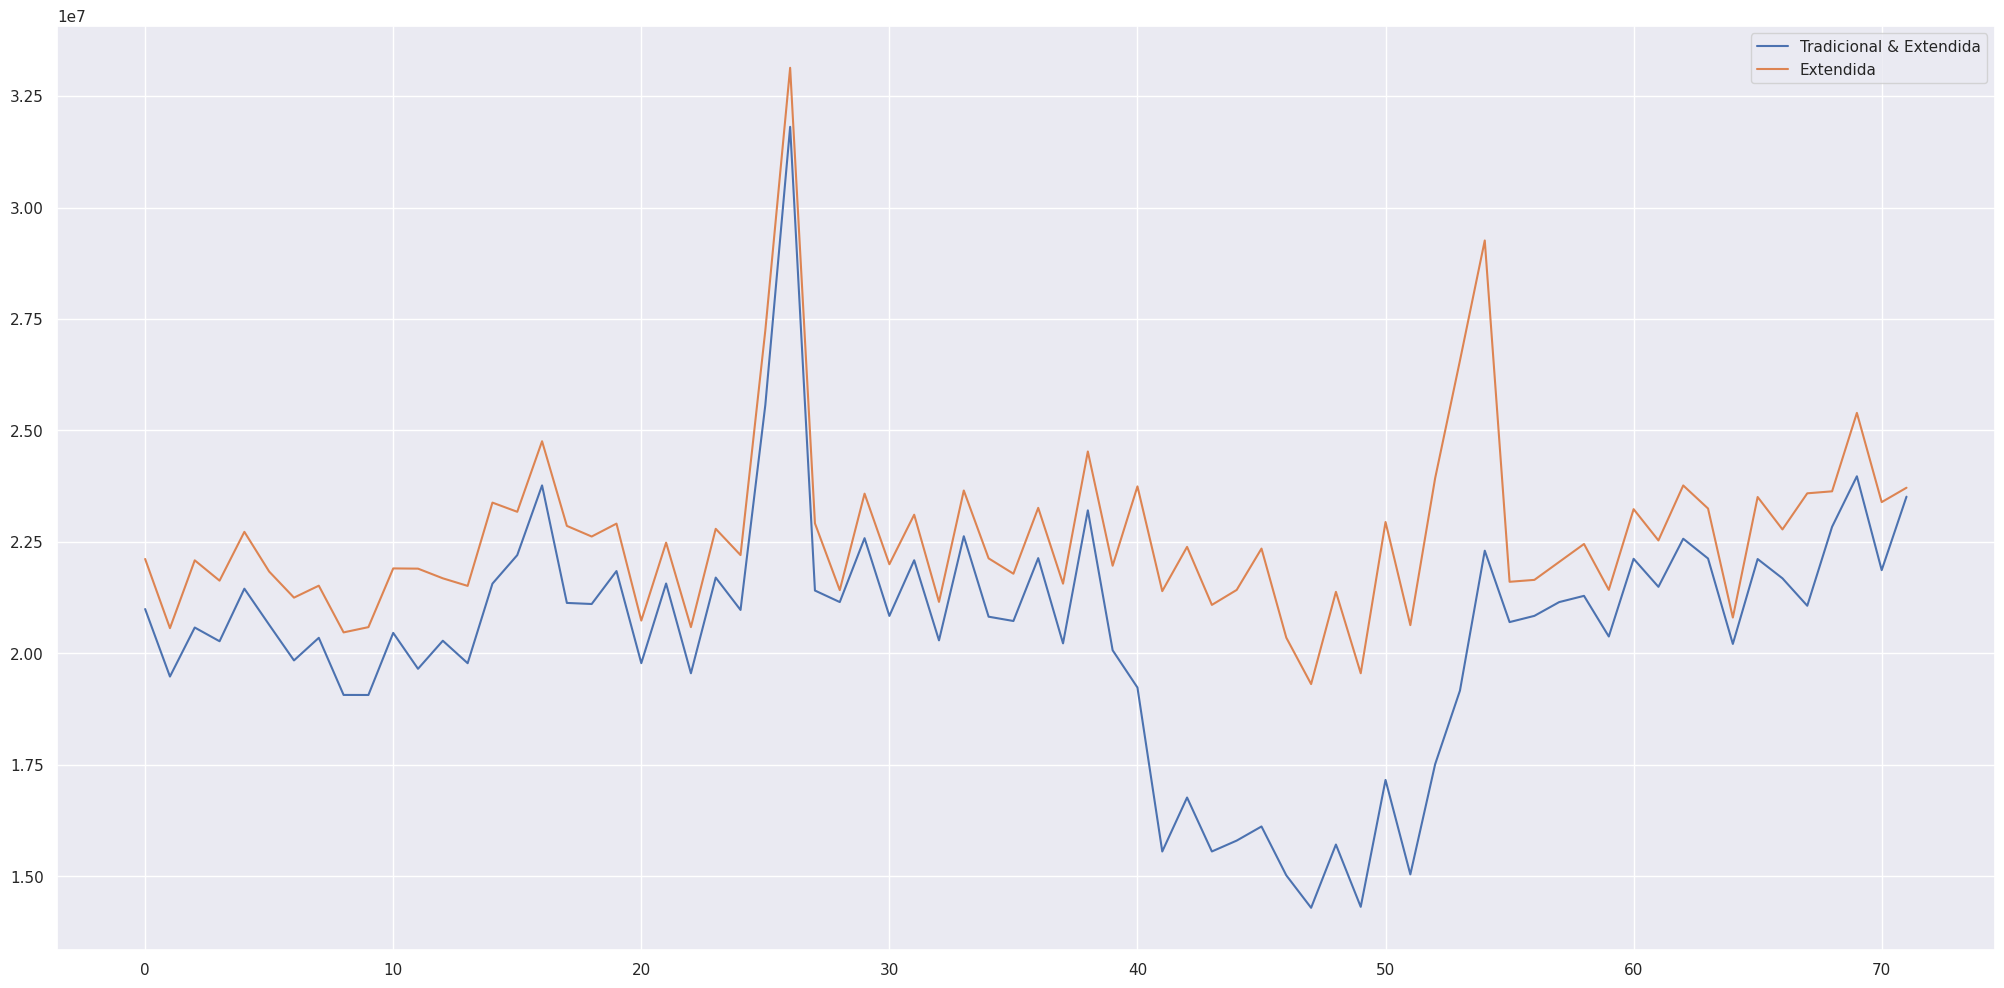

In [34]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

#### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

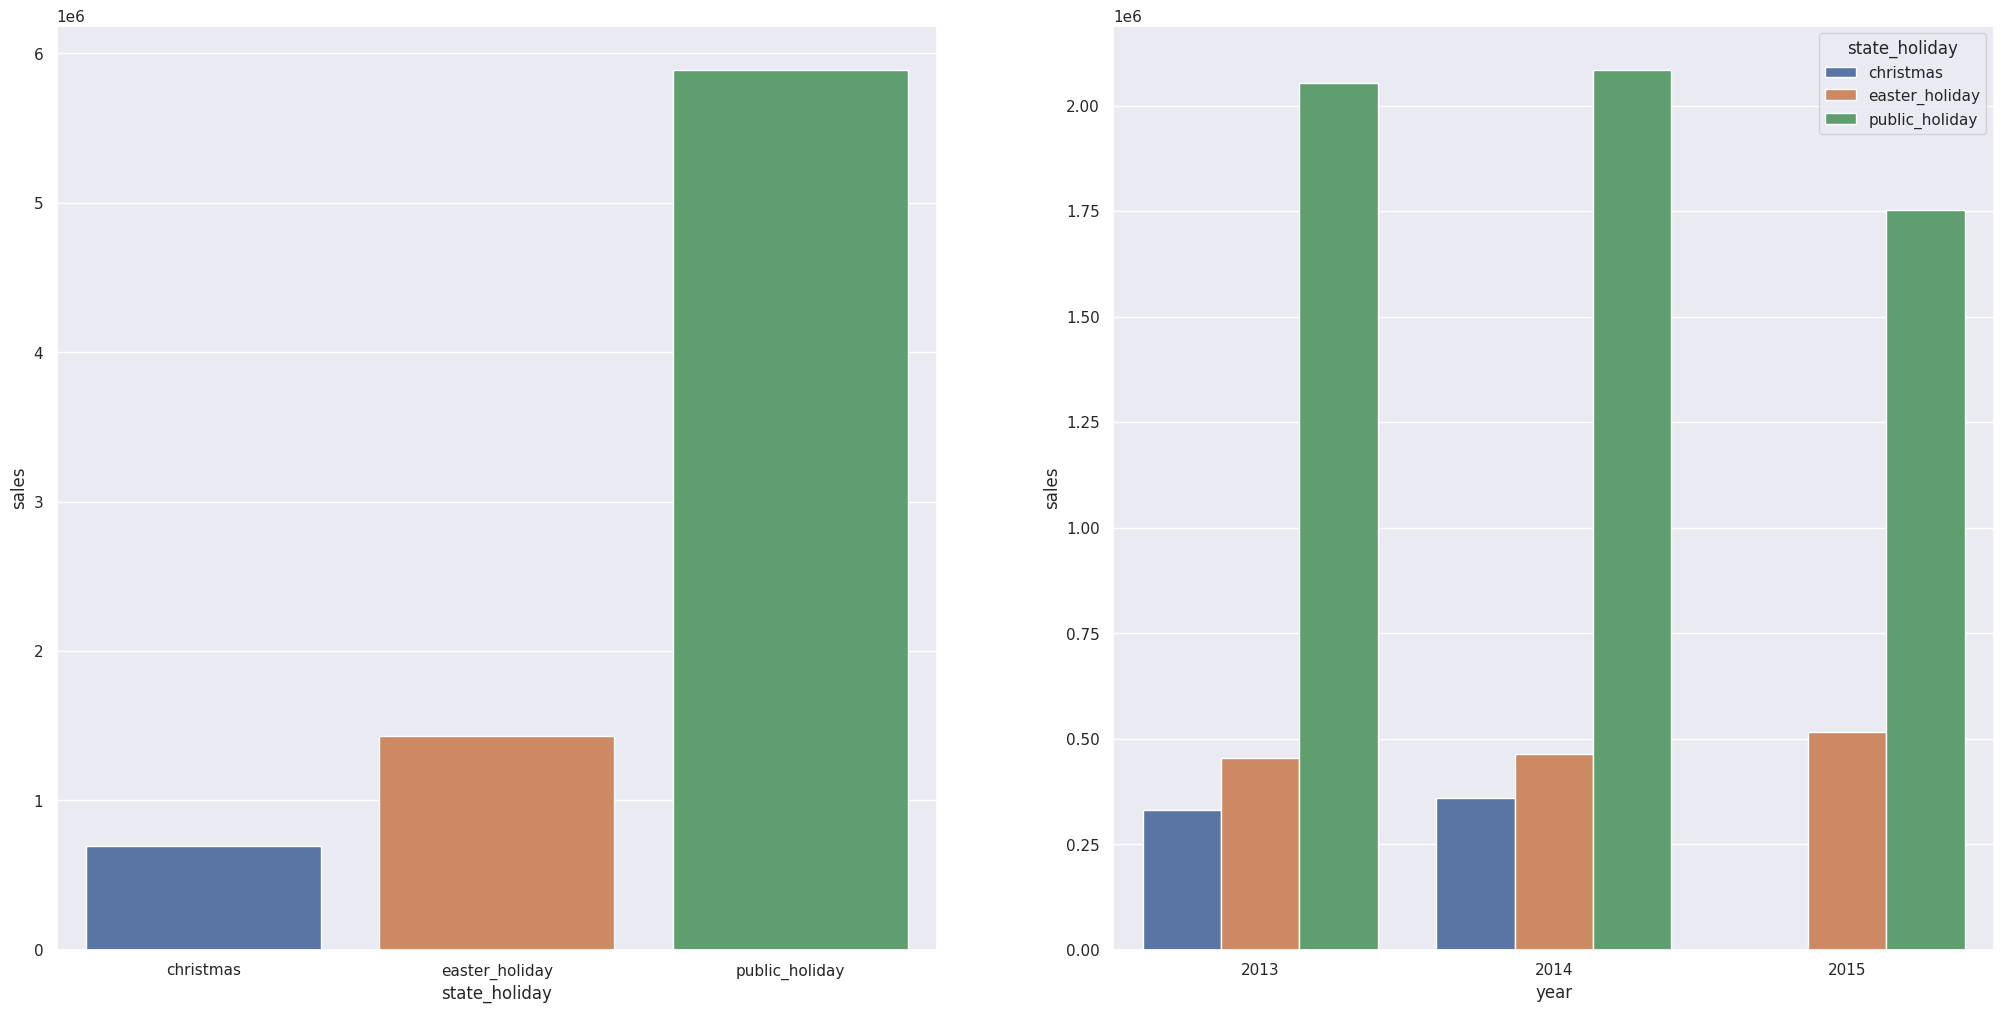

In [35]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

#### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

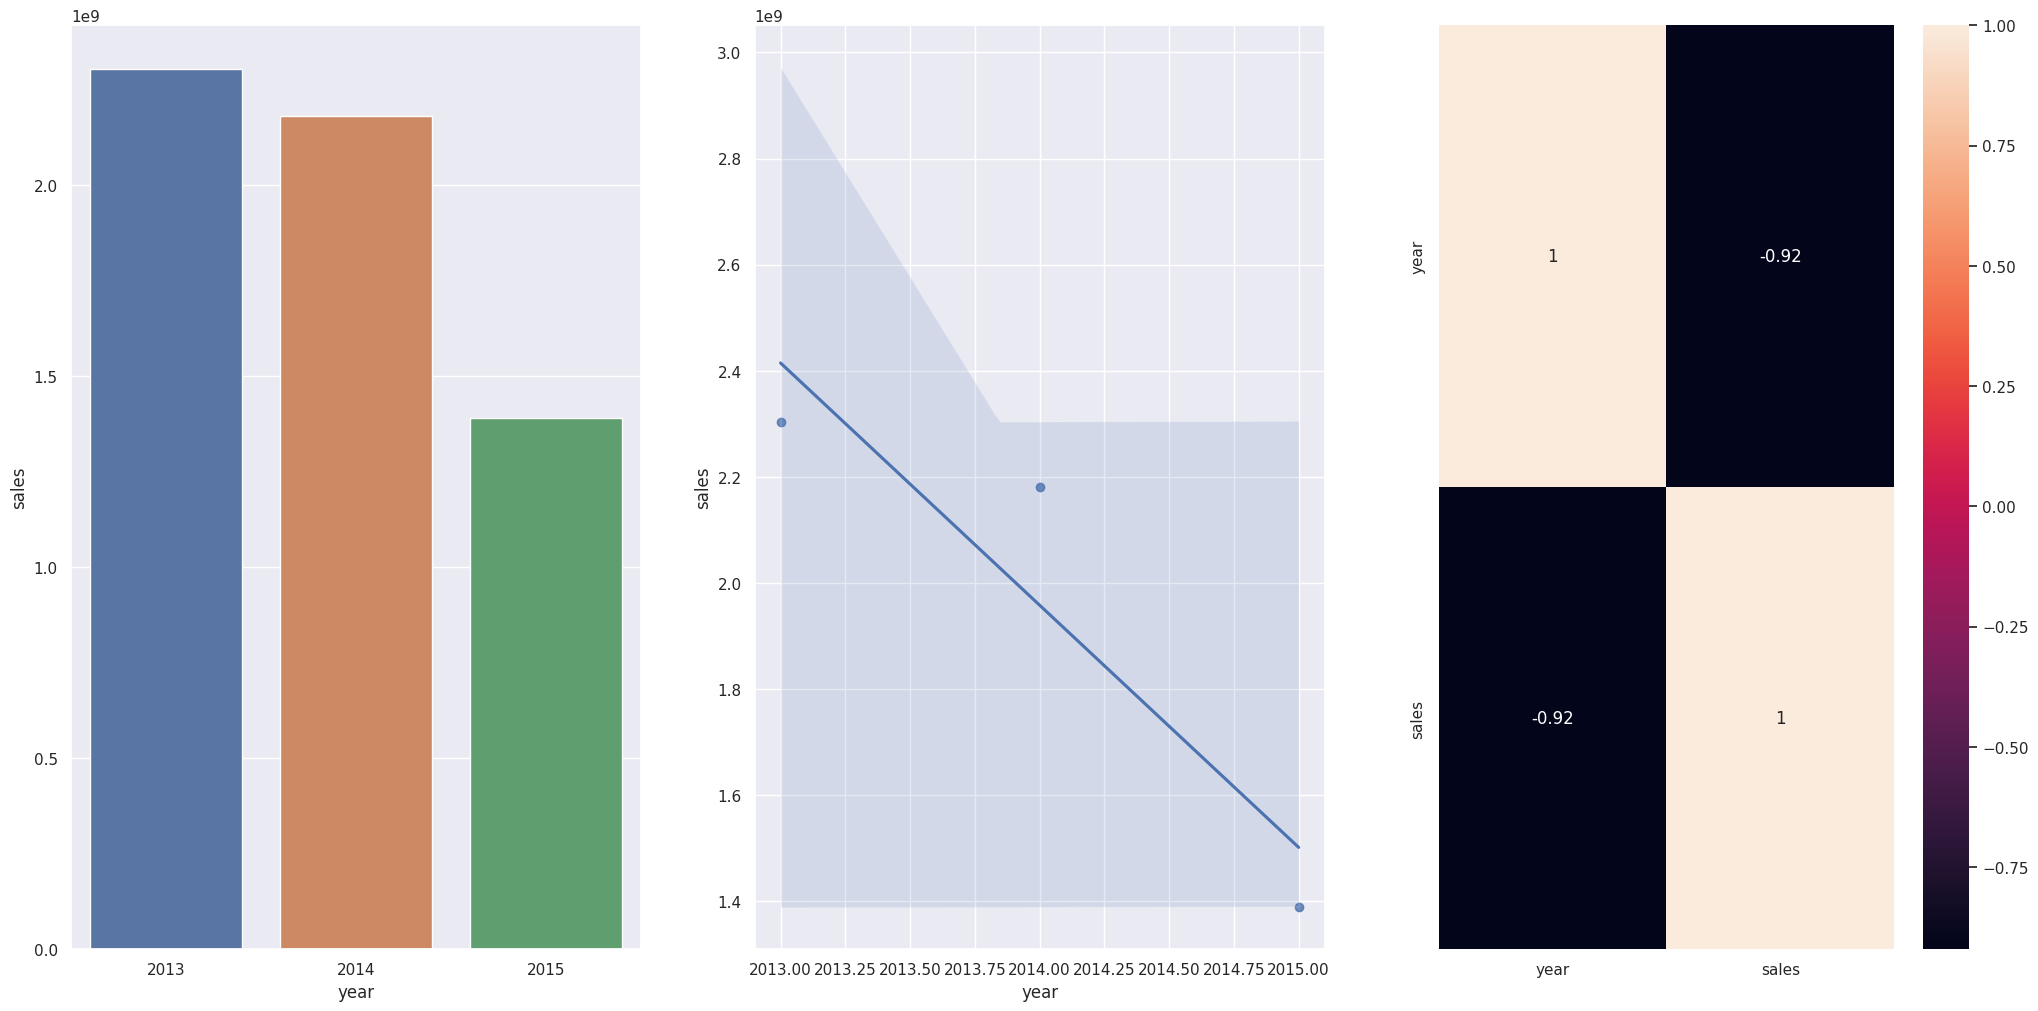

In [36]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

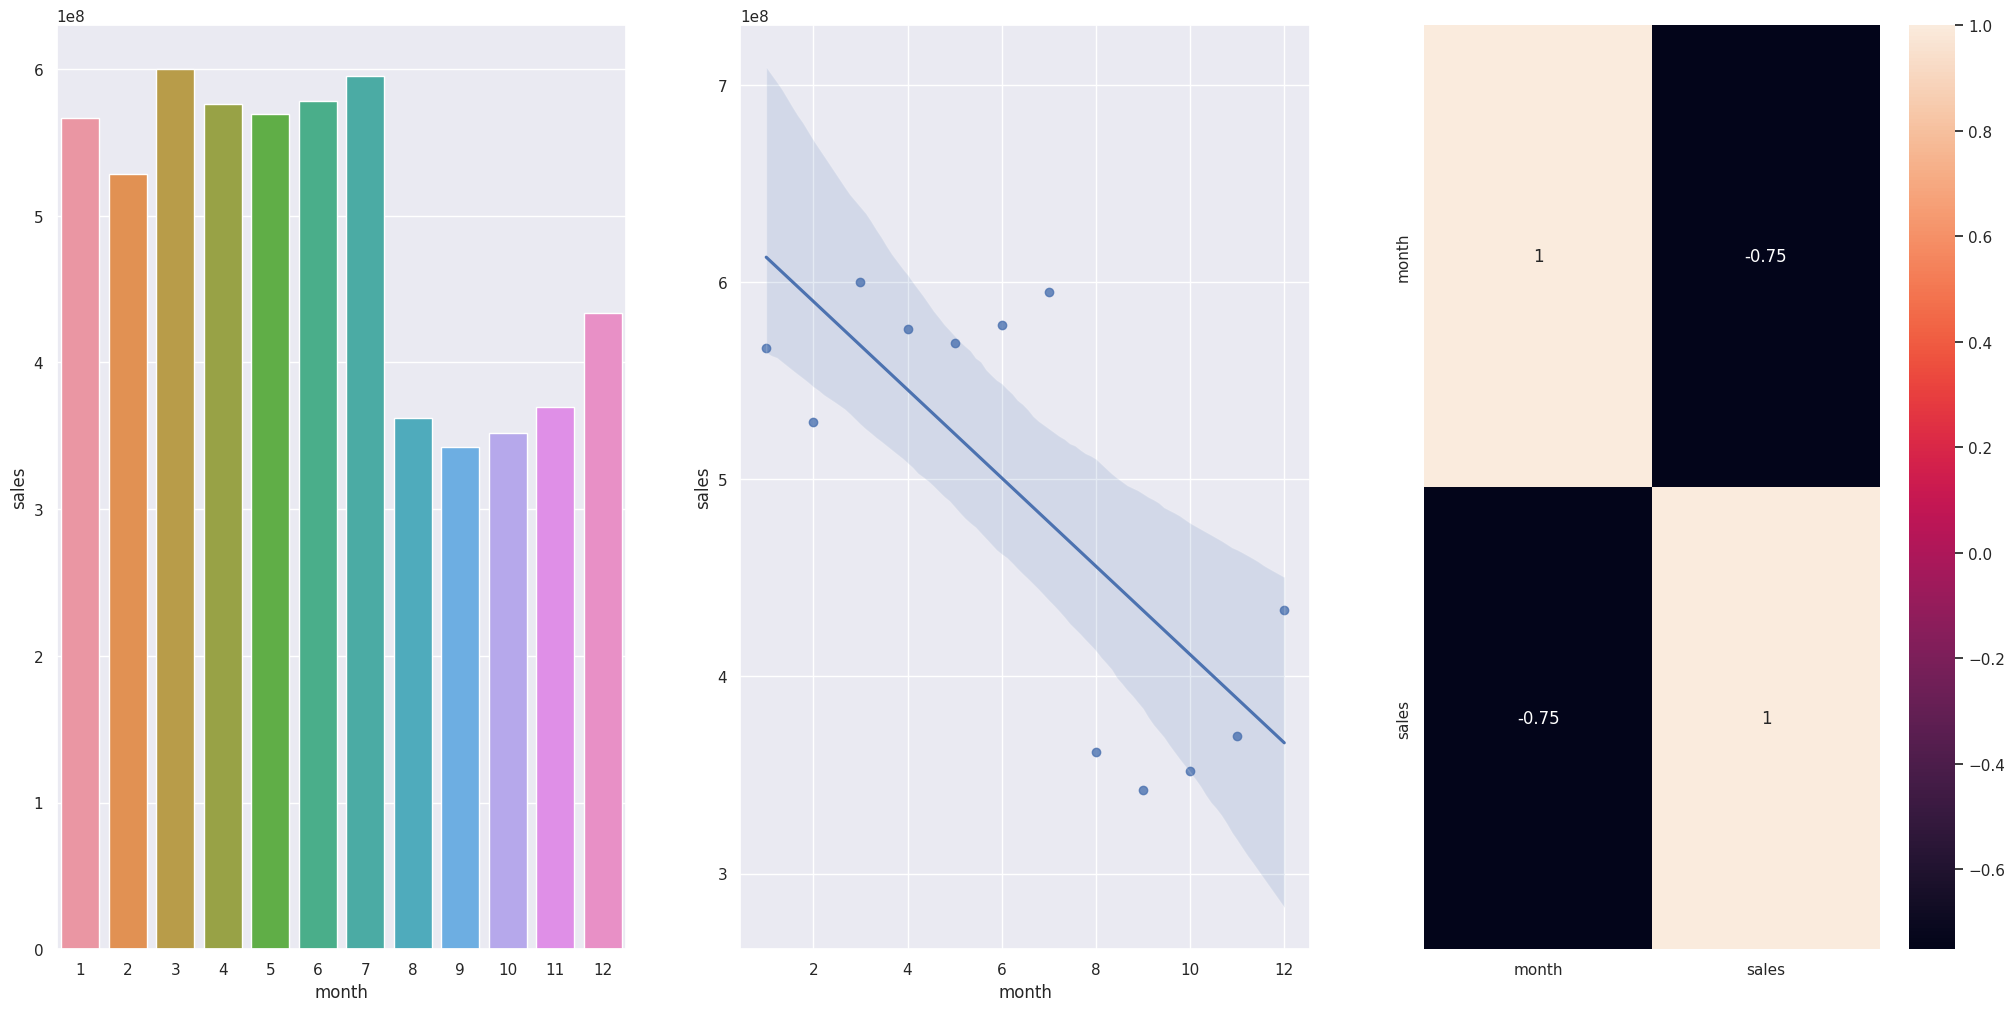

In [37]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

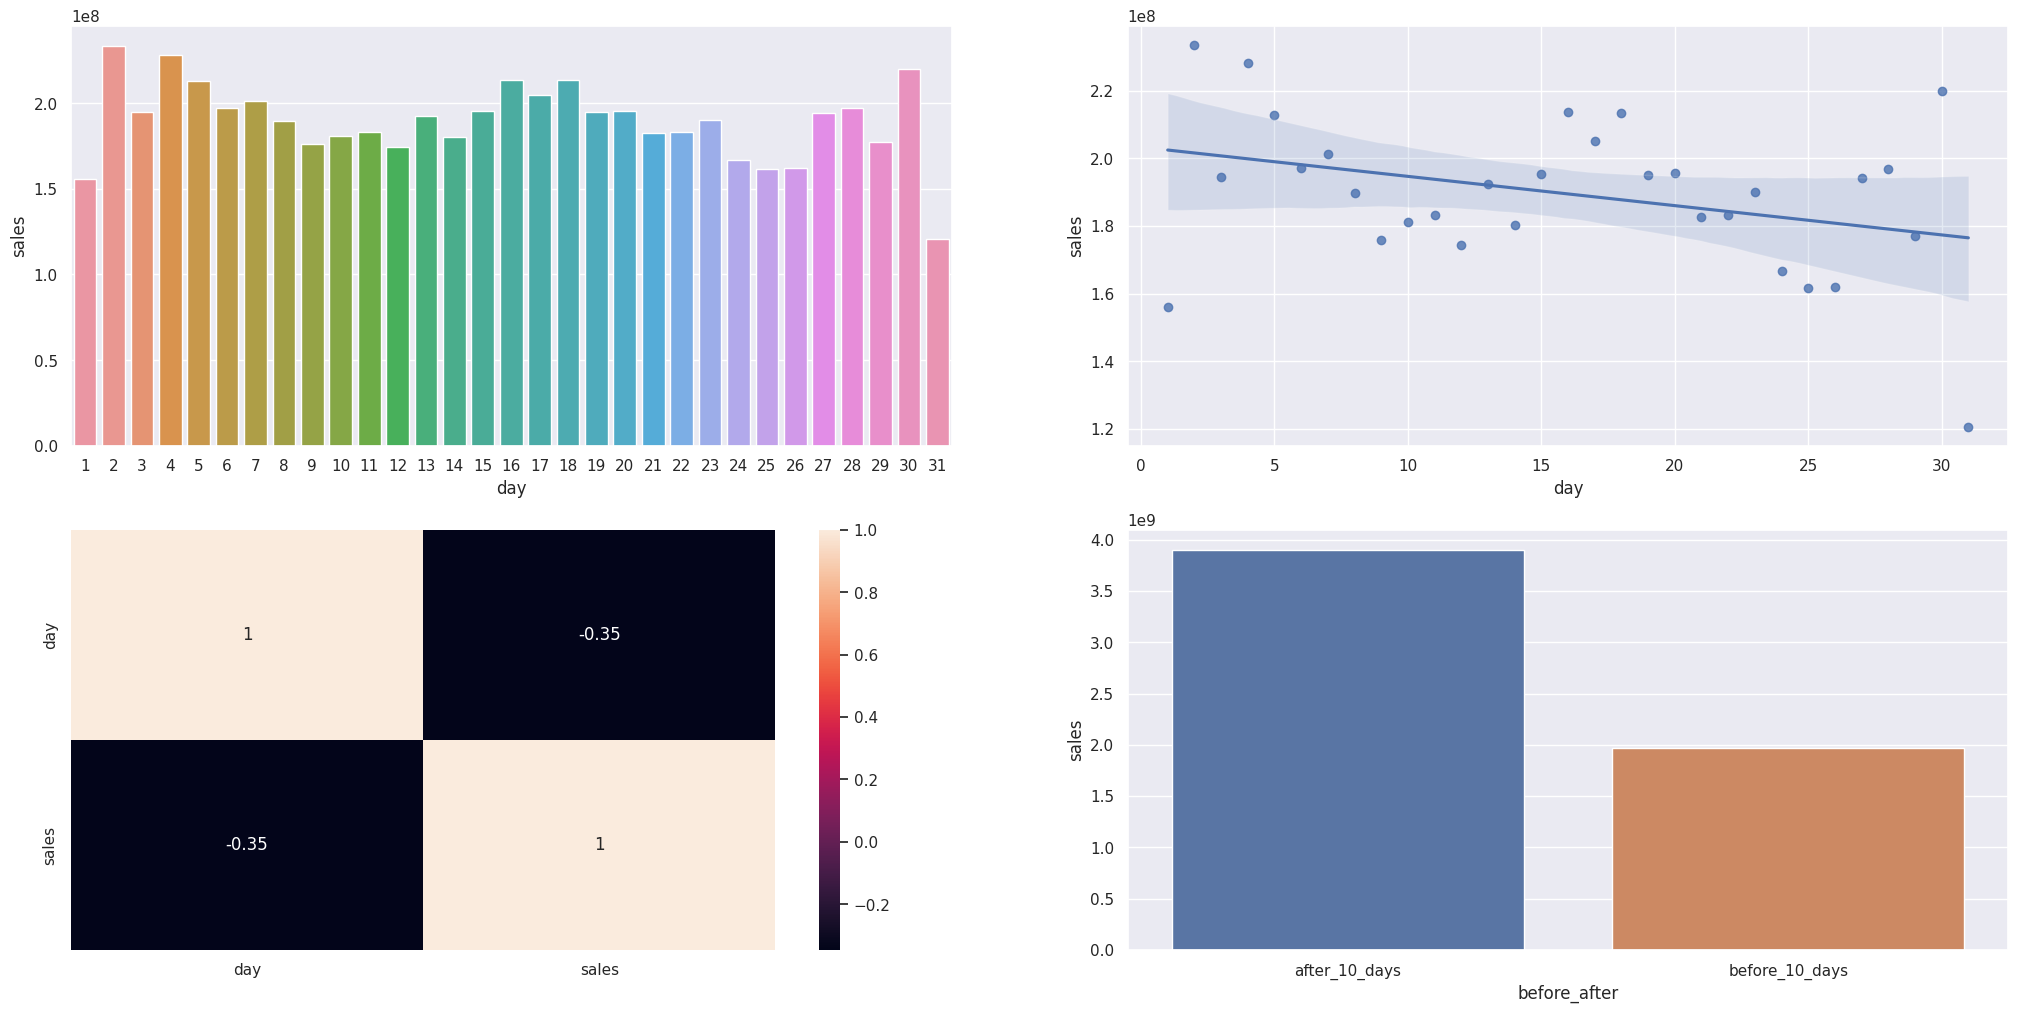

In [38]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

#### **H12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

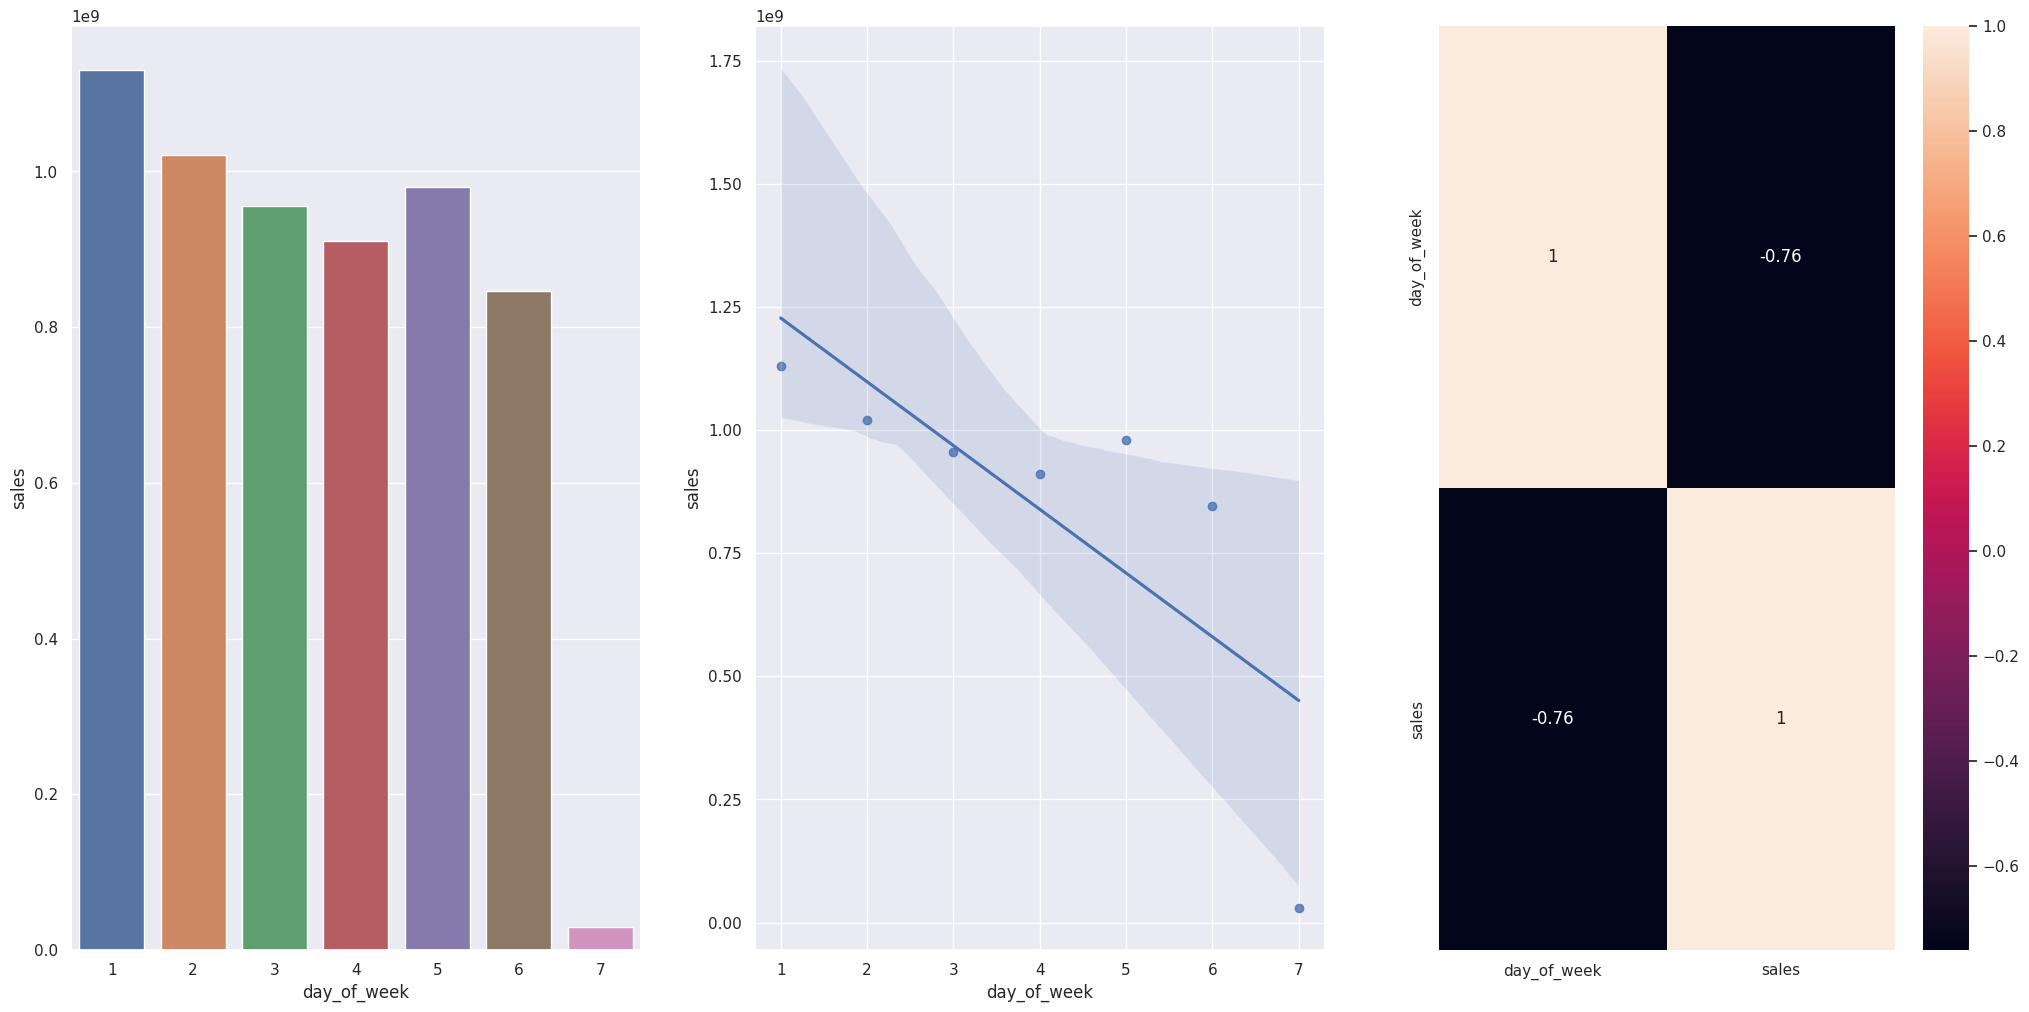

In [39]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

#### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

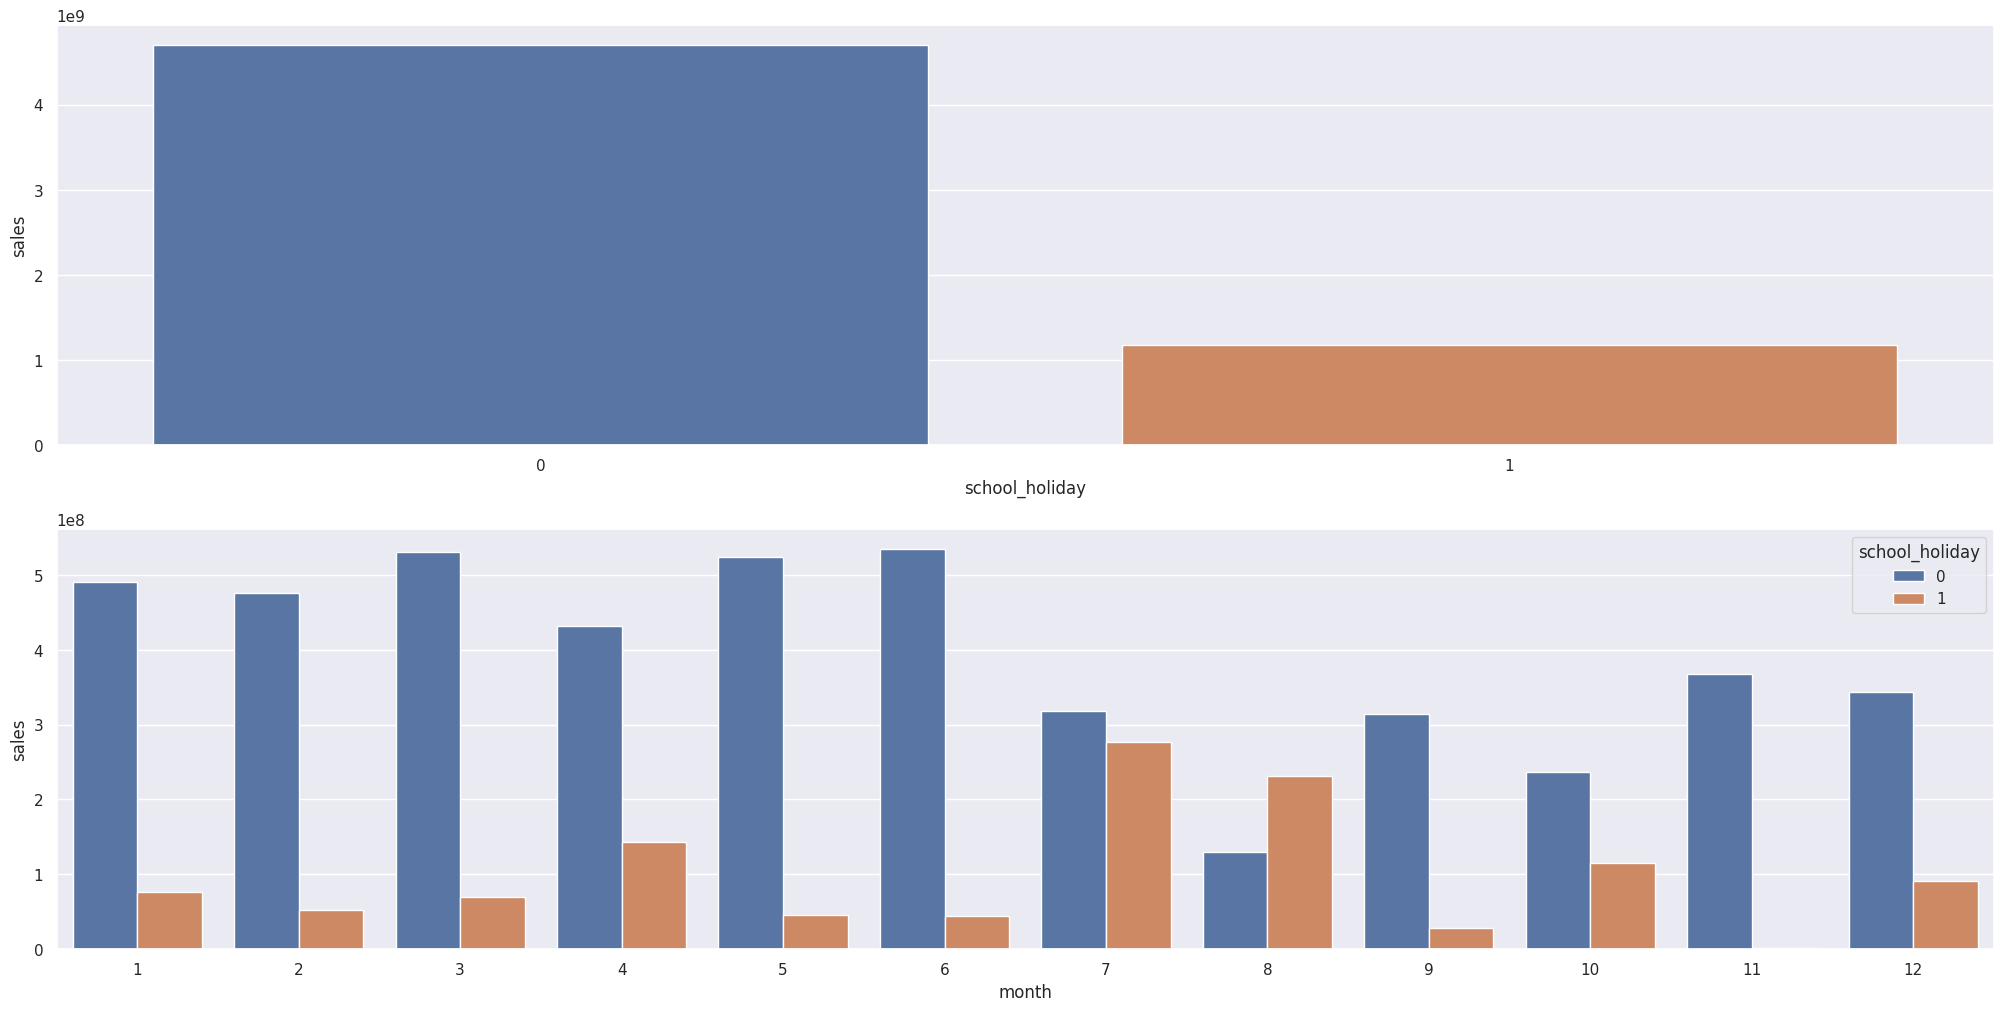

In [40]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

#### 4.2.1. Resumo das Hipoteses

In [41]:
from tabulate import tabulate

In [42]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


### 4.3. Analise Multivariada

#### 4.3.1. Numerical Attributes

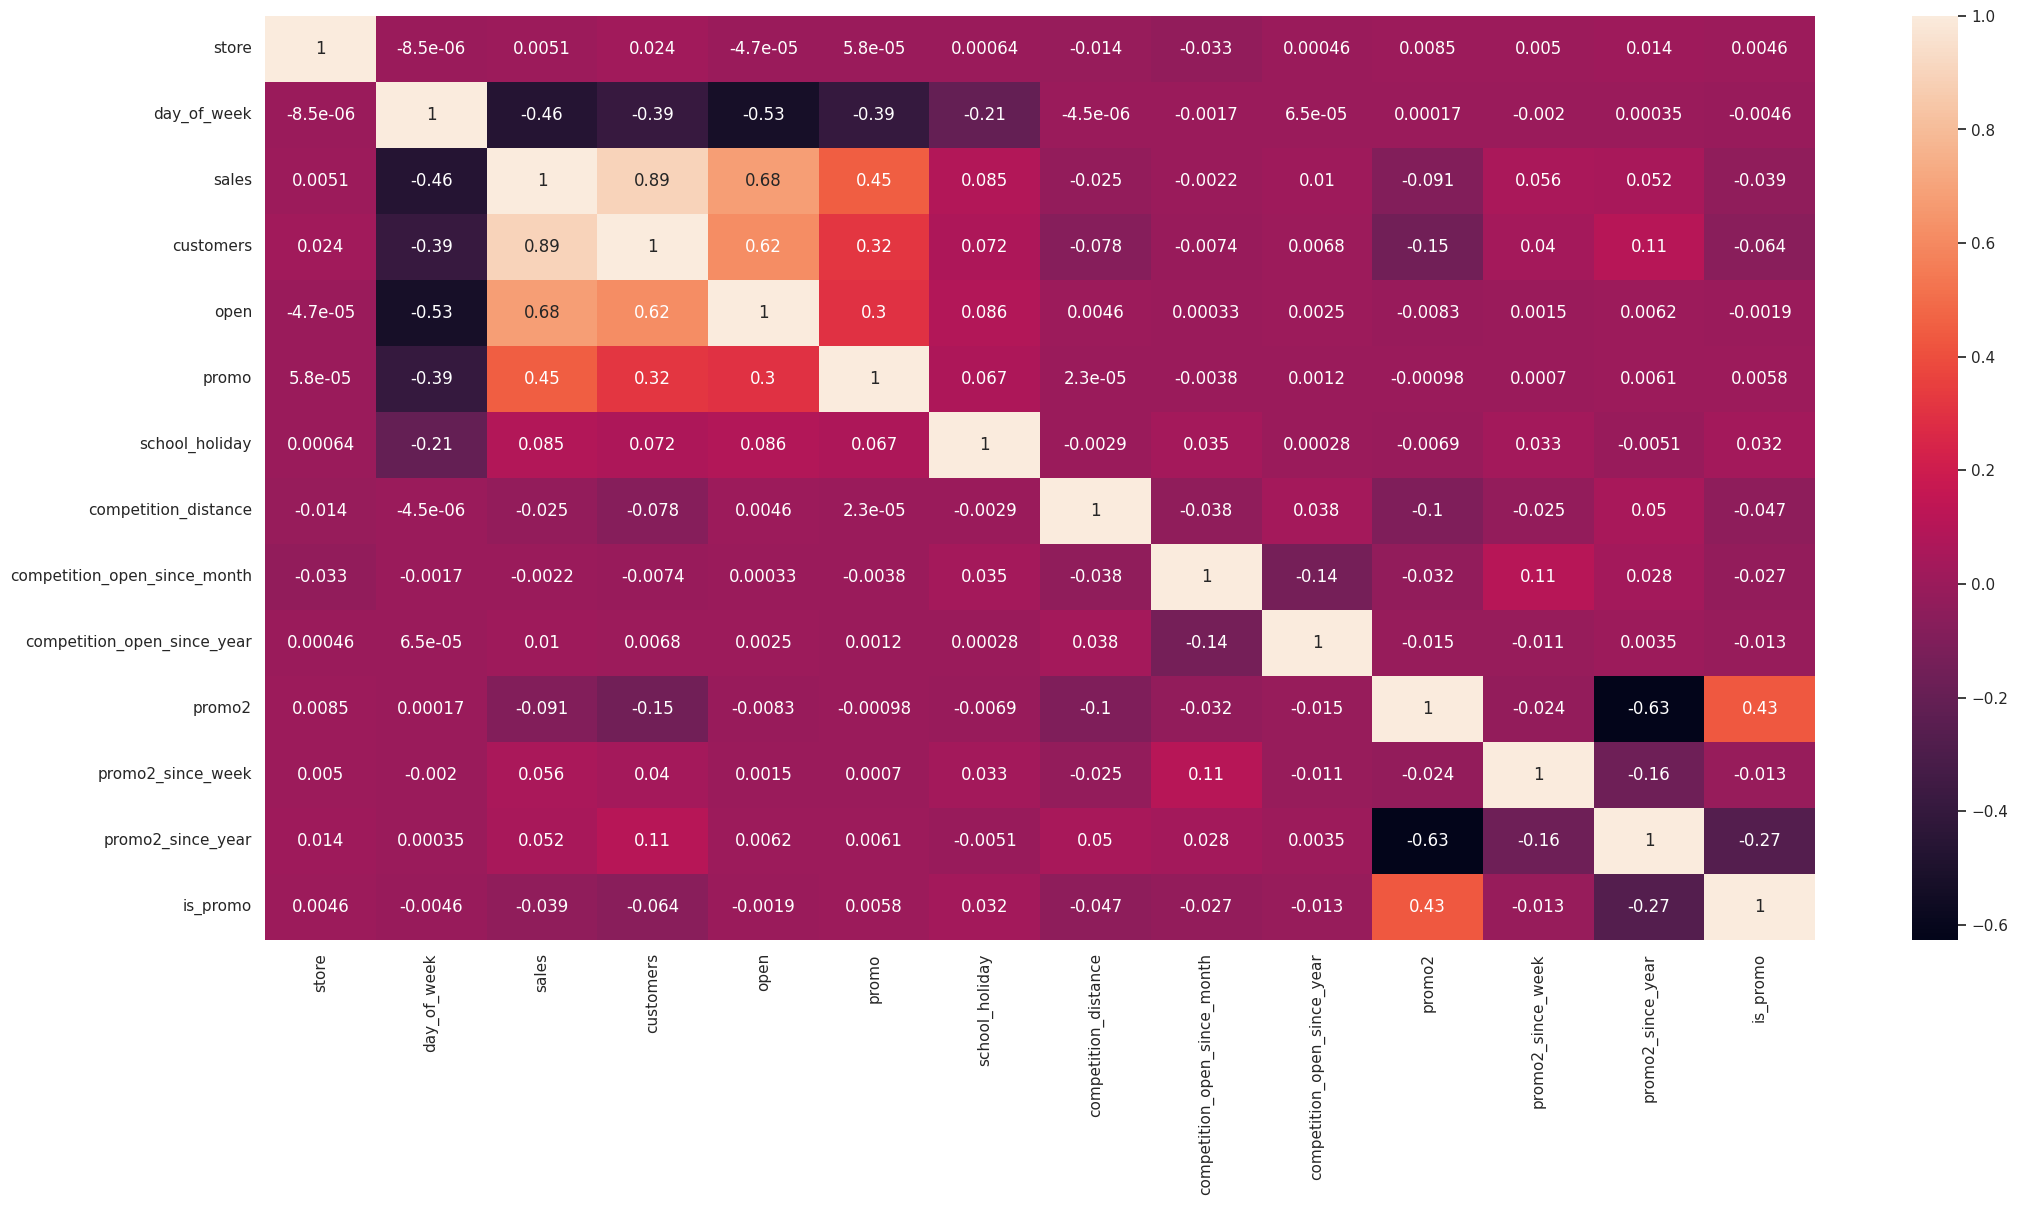

In [43]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

#### 4.3.2. Categorical Attributes

<AxesSubplot: >

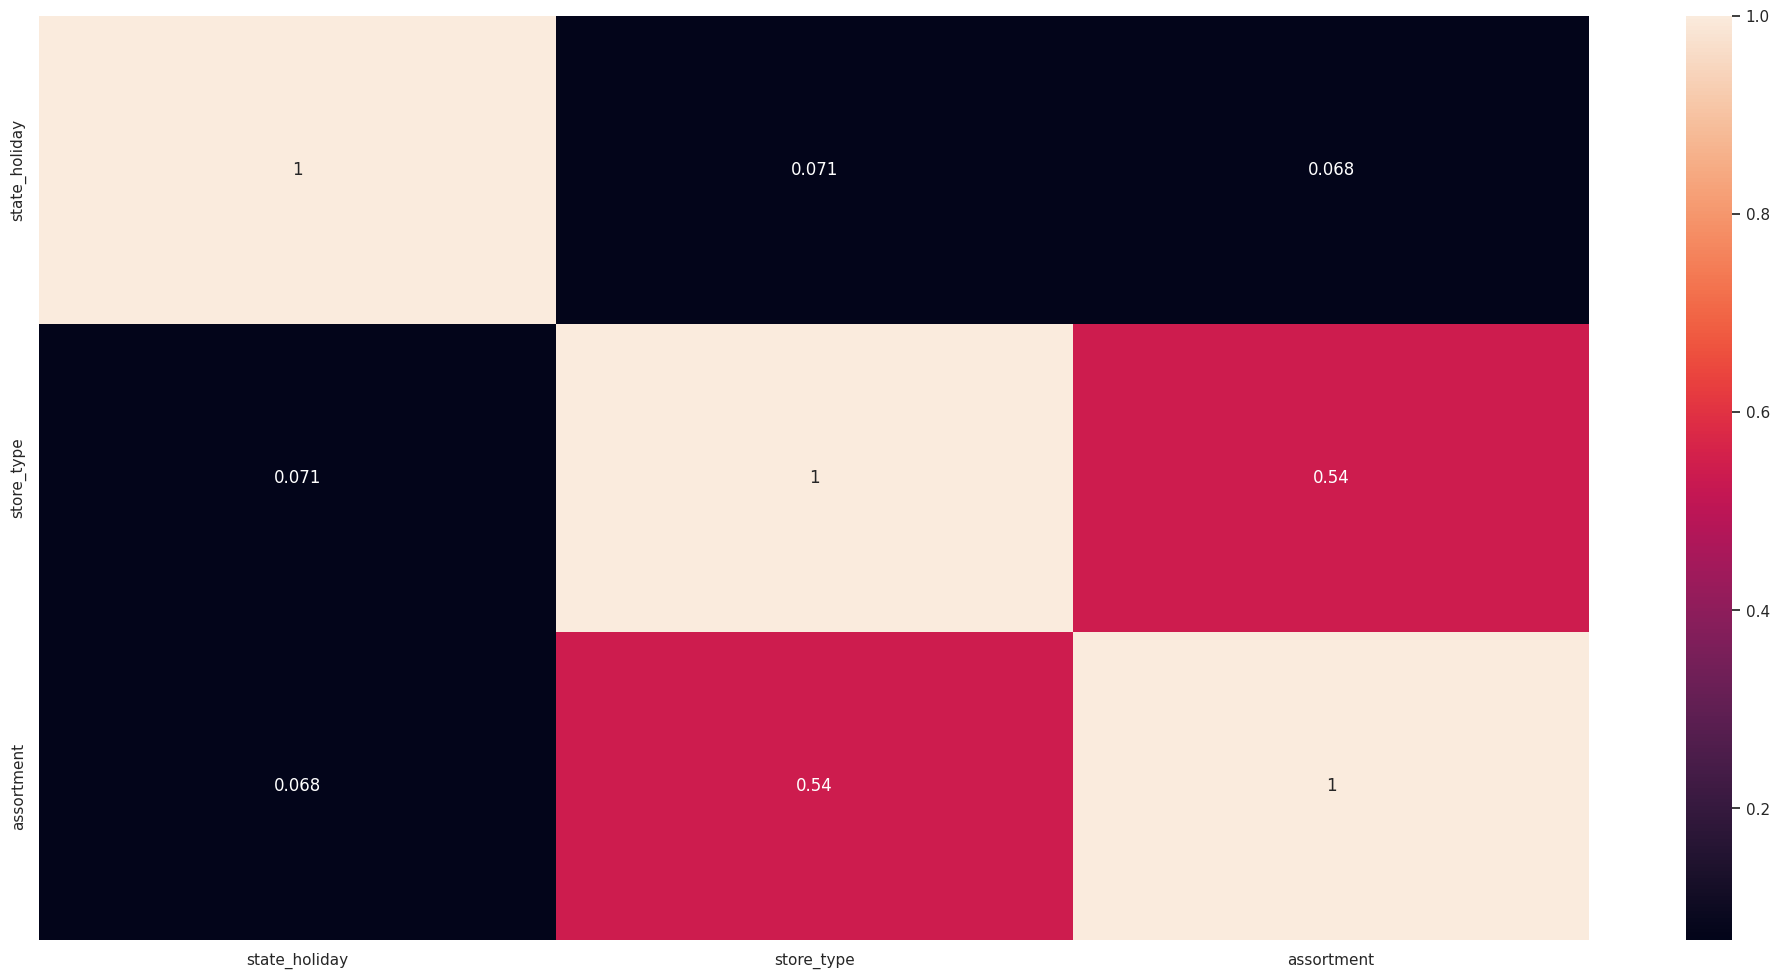

In [44]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

## 5.0. Passo 5 - Preparação dos Dados

In [45]:
df5 = df4.copy()

### 5.1. Normalizacao

In [46]:
#Não faremos normalização nestes dados

### 5.2. Rescaling

Primeira tecnica de Rescaling
- Min Max Scaler: Mantem o padrão nas distribuições, porem muito sensivel para variaveis com outliers
- Robust Scaler : Mantem a ideia do min max scaler olhando apenas os qartils, tirando a sensibilidade dos outliers

In [47]:
rs = RobustScaler()
mms = MinMaxScaler()

# Aplicando o RobustScaler

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

#Aplicando o MinMaxScaler

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

### 5.3. Transformacao

#### 5.3.1. Encoding

In [48]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

#### 5.3.2. Transformação de Grandeza - Variavel Resposta

In [49]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.3. Transformação de Natureza

In [50]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [51]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.0. Passo 6 - Feature Selection

In [52]:
df6 = df5.copy()

In [53]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop(cols_drop, axis=1)

### 6.1 Split dataframe into training and test dataset

In [54]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print(f"Training Min Date: {X_train['date'].min()}")
print(f"Training Max Date: {X_train['date'].max()}")
print(f"\nTest Min Date: {X_test['date'].min()}")
print(f"Test Max Date: {X_test['date'].max()}")

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 6.2 Boruta as Feature Selector

In [55]:
#traning and test dataset for Boruta
#X_train_n = X_train.drop(['date','sales'],axis=1).values
#y_train_n = y_train.values.ravel()

#define Random Forest Regressor 
#rf = RandomForestRegressor(n_jobs=-1)

#define Boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(X_train_n,y_train_n)

#### 6.2.1. Best Features from Boruta

In [56]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

### 6.3 Boruta Manual result from feature selection

In [57]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

In [58]:
# columns to add
feat_to_add = ['date', 'sales']
#cols_selected_boruta_full = cols_selected_boruta.copy()
#cols_selected_boruta_full.extend( feat_to_add )

## 7.0. Passo 7 - Machine Learning Modeling

In [59]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

### 7.1 Avarage Model

In [60]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

#performace
baseline_result = ml_error('Avarage Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.2064,1835.135542


### 7.2 Linear Regression Model

In [61]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.3 Linear Regression Regularized Model

In [68]:
#Model
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

#Prediction
yhat_lrr = lrr.predict(x_test)

#Performance
lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.4 Random Forest Regressor

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)

#Prediction
yhat_rf = rf.predict(x_test)

#Performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

### 7.5 XGBoost Regressor

In [ ]:
import xgboost as xgb

In [ ]:
#Model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,eta=0.01,max_depth=10,subsample=0.7,colsample_bytree=0.9).fit(x_train,y_train)

#Prediction
yhat_xgb = model_xgb.predict(x_test)

#Performance
xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_result

### 7.6 Compare Models Performance

In [ ]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RMSE')